# 知名基金经理的一天

你是一名知名基金的基金经理。



## Story 1: 缘起指数

2016年底，其他几间机构的销售经理向你推荐了几只完全复制指数收益和风险构成的基金，这些基金复制如下指数：

1. S&P 500；
2. NASDAQ ；
3. 上证指数；
4. 深证成分股票指数；
5. 创业板指数；
6. 恒生指数；
7. Core US Aggregate Bond Index（美国债券指数）

同时，你还可以选择投资 *8. 黄金ETF GLD基金*。

你的助理已经帮你收集了8种指数/商品的历史日收益。现在你决定构建一个最优化组合，目标是：

1. 组合的标准差最小；
2. 至少持有15%的纳斯达克；
3. 美国债券持有量不超过30%；
4. 不允许做空；
5. 所有资产权重总和为1。

【注：忽略汇率对指数的影响，每年交易日设定为250】


### 任务1: 按照要求构建最优组合

1. 从'source_data.xlsx'中导入各原始数据；
2. 计算过去三年（2013-12-31至2016-12-31）和五年（2011-12-31至2016-12-31）的收益率和协方差矩阵；
3. 利用3年数据和5年数据分别绘制出有效前沿；
4. 根据约束条件，构建标准差最小的投资组合；
5. 阐述结果的合理性。

# 一、数据预处理

#### 1. 从'source_data.xlsx'中导入各原始数据；

In [2]:
import pandas as pd
import datetime
import time
file = 'source_data.xlsx'

xl = pd.ExcelFile(file)
data_all = {}

for i in xl.sheet_names:
    data_all[i] = pd.read_excel(io = file,sheet_name=i)

returns = pd.DataFrame(columns=['Date','GLD'])      
  
#"有数据重复"
#import collections
#print(item for item, count in collections.Counter(h).items() if count > 1)
#data_all['S&P500'].ix[1741:1743]

h = []
k = []
for i in range(len(data_all['GLD']['Date'])):
   h.append(data_all['GLD']['Date'][i])
   k.append(data_all['GLD']['index'][i])       

returns['Date'] = h.copy()            
returns['GLD'] = k.copy()       
returns = returns.set_index('Date')

for i in xl.sheet_names[:-1]:
    h = []
    k = []
    for j in range(len(data_all[i]['Date'])):
        h.append(data_all[i]['Date'][j])
        k.append(data_all[i]['index'][j])      
    result = pd.DataFrame()
    result['Date'] = h.copy()
    result[i] = k.copy()
    result = result.set_index('Date')
    returns = returns.join(result)

returns = returns.drop(['NaT'])
#用前一个数据代替NaN：method='pad'
returns = returns.fillna(method = 'pad')
#bfill表示用后一个数据代替NaN
returns = returns.fillna(method = 'bfill')
returns.to_csv('并集指数.csv', sep = ',', index = True)

#### 2.数据清洗

##### 2.1 过去三年

In [6]:
df = pd.read_csv('并集指数.csv')
data_2013 = df[1227:1984]
data_2013.head()
# data_2013.tail()

Date     GLD   S&P500   NASDAQ     上证指数     深圳成指    创业板指数  \
1227  2013-12-31  116.12  1848.36  4176.59  2115.98  8121.79  1304.44   
1228  2014-01-02     118  1831.98  4143.07  2109.39  8114.39  1333.00   
1229  2014-01-03  119.29  1831.37  4131.91  2083.14  8028.33  1352.84   
1230  2014-01-06   119.5  1826.77  4113.68  2045.71  7818.46  1323.33   
1231  2014-01-07  118.82  1837.88  4153.18  2047.32  7806.31  1352.28   

          恒生指数    美国债券  
1227  23306.39  106.43  
1228  23340.05   106.5  
1229  22817.28  106.54  
1230  22684.15  106.68  
1231  22712.78  106.73

In [11]:
df = pd.read_csv('并集指数.csv')
df.head()
'''
截取数据
'''
df = df[1227:1984]
df.to_csv('3years.csv', sep=',')

##### 2.2 过去五年

# 二、先计算3年的情况（2013-12-31至2016-12-31）
### 数据归一化

In [10]:
import pandas as pd
import numpy as np

df = pd.read_csv('3years.csv')  # 注意：3years.csv为预处理好的数据，可从此处开始执行
df.drop(['Unnamed: 0'], axis=1, inplace=True)
# print(df.head())
date = df.pop('Date') # 弹出日期列
# print(df.head())
df = df/df.loc[0]*100 # 统一缩放到100为基点
df.head()

GLD      S&P500      NASDAQ        上证指数        深圳成指       创业板指数  \
0  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
1  101.619015   99.113809   99.197431   99.688560   99.908887  102.189445   
2  102.729935   99.080807   98.930228   98.448000   98.849268  103.710404   
3  102.910782   98.831938   98.493747   96.679080   96.265232  101.448131   
4  102.325181   99.433011   99.439495   96.755168   96.115635  103.667474   

         恒生指数        美国债券  
0  100.000000  100.000000  
1  100.144424  100.065771  
2   97.901391  100.103354  
3   97.330174  100.234896  
4   97.453016  100.281875

### 绘制各指数走势

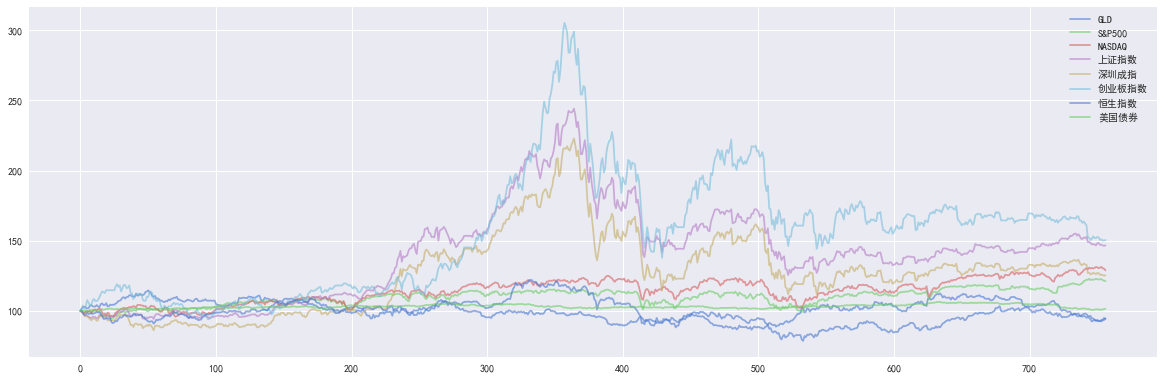

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
style.use('fivethirtyeight')

sns.set(palette="muted", color_codes=True)
fig, axes = plt.subplots(1,1,figsize=(18, 6))

def plot(data):
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.plot(data, label=data.name, alpha=.6)
    
df.apply(plot)
plt.legend() 
plt.show()

### 计算收益率
Markowitz模型基于资产收益和波动，因此需要将指数价格转换为收益率。这里采用简单收益率：

> $R_{t}=\frac{P_{t}-P_{t-1}}{P_{t-1}}$

In [12]:
returns_df = (df-df.shift(1))/df.shift(1) # 简单收益率
# returns_df = np.log(df/df.shift(1)) # 对数收益率
returns_df.dropna(axis='index', inplace=True) # 删除空数据
returns_df.head()

GLD    S&P500    NASDAQ      上证指数      深圳成指     创业板指数      恒生指数  \
1  0.016190 -0.008862 -0.008026 -0.003114 -0.000911  0.021894  0.001444   
2  0.010932 -0.000333 -0.002694 -0.012444 -0.010606  0.014884 -0.022398   
3  0.001760 -0.002512 -0.004412 -0.017968 -0.026141 -0.021813 -0.005835   
4 -0.005690  0.006082  0.009602  0.000787 -0.001554  0.021877  0.001262   
5 -0.005891 -0.000212  0.002993 -0.001456 -0.000534  0.039001  0.012496   

       美国债券  
1  0.000658  
2  0.000376  
3  0.001314  
4  0.000469  
5 -0.002998

### 查看收益率分布直方图

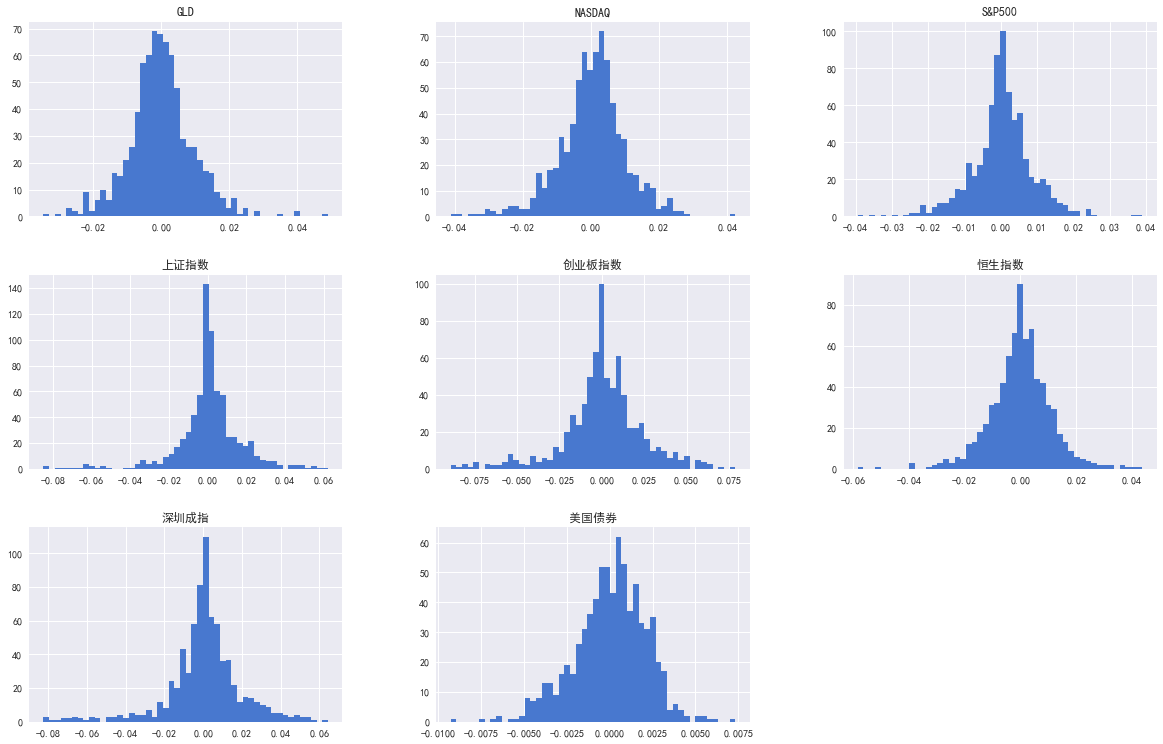

In [84]:
hist = returns_df.hist(bins=50, figsize=(18, 12)) # 查看收益率分布
plt.show()

## 利用Markowitz模型构建投资组合

### 计算年化收益率

年化收益率有两种计算方式：

* 算数平均算法：$年化收益率=\frac{R_{T}}{T}*m$
* 几何平均算法：$年化收益率=[(1+R_{T})^\frac{m}{T}]-1$

In [16]:
year_ret = np.power(1+returns_df.mean(), 250)-1 # 几何年化收益
year_ret

GLD      -0.007803
S&P500    0.075045
NASDAQ    0.100854
上证指数      0.178313
深圳成指      0.131913
创业板指数     0.229209
恒生指数     -0.003211
美国债券      0.005594
dtype: float64

### 标准差
标准差$\sigma = \sqrt{\frac{1}{T}\sum_{t=1}^{T}{(R_{t}-\bar{R})}^2}$

In [57]:
sigma = returns_df.std() * (250**0.5)
sigma

GLD       0.150196
S&P500    0.134086
NASDAQ    0.155938
上证指数      0.272316
深圳成指      0.312550
创业板指数     0.376582
恒生指数      0.177787
美国债券      0.033254
dtype: float64

### 协方差矩阵
组合的收益率 = $\mu_{p}=E(r_{p})=\sum_{i=1}^N{\omega_i}E(r_{i})$

组合的方差 = $\sigma_{p}^2=\sum_{i=1}^N\sum_{j=1}^N{\omega_i}\omega_j\sigma_{ij}$

In [14]:
year_cov = returns_df.cov()*250
year_cov

GLD    S&P500    NASDAQ      上证指数      深圳成指     创业板指数      恒生指数  \
GLD     0.022559 -0.003644 -0.004550 -0.002752 -0.002714 -0.002045 -0.003861   
S&P500 -0.003644  0.017979  0.019397  0.005609  0.006299  0.006492  0.005443   
NASDAQ -0.004550  0.019397  0.024317  0.007121  0.007930  0.008466  0.007102   
上证指数   -0.002752  0.005609  0.007121  0.074156  0.078714  0.073433  0.023996   
深圳成指   -0.002714  0.006299  0.007930  0.078714  0.097688  0.099114  0.025116   
创业板指数  -0.002045  0.006492  0.008466  0.073433  0.099114  0.141814  0.022594   
恒生指数   -0.003861  0.005443  0.007102  0.023996  0.025116  0.022594  0.031608   
美国债券    0.001729 -0.001121 -0.001151 -0.000417 -0.000498 -0.000556 -0.000400   

            美国债券  
GLD     0.001729  
S&P500 -0.001121  
NASDAQ -0.001151  
上证指数   -0.000417  
深圳成指   -0.000498  
创业板指数  -0.000556  
恒生指数   -0.000400  
美国债券    0.001106

### 相关系数
相关系数$\rho_{A,B}=\frac{\sigma_{AB}}{\sigma_{A}\sigma_{B}}$ 

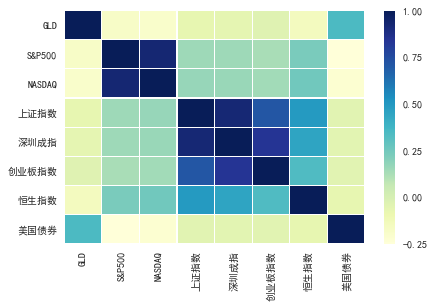

In [59]:
corr = returns_df.corr()
corr_heatmap = sns.heatmap(corr, cmap="YlGnBu", linewidths=.2)
plt.show()

### 计算可行域

组合的收益率 = $\mu_{p}=E(r_{p})=\sum_{i=1}^N{\omega_i}E(r_{i})$

组合的标准差 = $\sigma_{p}^2=\sum_{i=1}^N\sum_{j=1}^N{\omega_i}\omega_j\sigma_{ij}$

将上面的公式向量化，设$\vec{\omega}=\{\omega_{1},\omega_{2},\omega_{3},...\}$，则

> $\mu_{p}= \vec{\omega}^TR$

> $\sigma_{p}^2=\vec{\omega}^TCOV\vec{\omega}$

利用蒙特卡洛模拟，模拟出各种可能权重下组合的收益率和标准差。用描点法，以组合标注差为横轴，以组合收益率为纵轴绘制散点图。

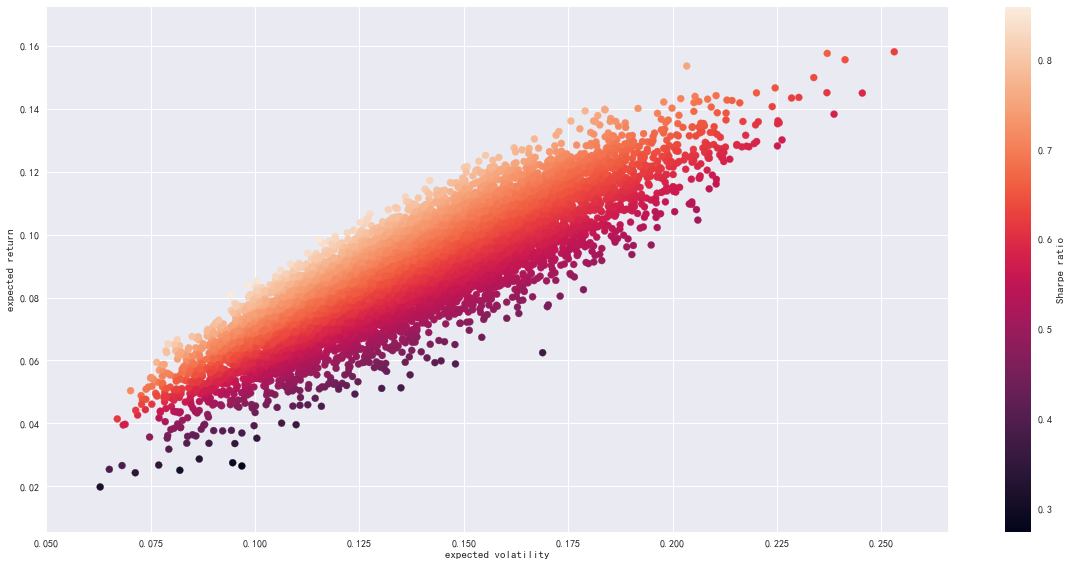

In [17]:
import time
from functools import reduce

sds = [] # 存放各组合标准差
rtn = [] # 存放各组合收益率
num = len(year_ret) # 资产数量
np.random.seed(int(time.time())) # 设置随机数种子

# 模拟1万次
for _ in range(10000):
    w = np.random.rand(num)   # 随机生成各项资产的权重
    w /= sum(w)               # 归一化
    rtn.append(sum(year_ret * w)) # 计算收益率
    sds.append(np.sqrt(reduce(np.dot, [w, year_cov, w.T]))) # 计算波动率
    
sds = np.array(sds)
rtn = np.array(rtn)

# xlim(xmin=0)
# ylim(ymin=0)
fig, axes = plt.subplots(1,1,figsize=(18, 9))
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.scatter(sds, rtn, c=rtn/sds, marker='o')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

### 绘制有效前沿

有效前沿就是上图中的左边界，它代表同一收益率水平下，风险水平最低的投资组合；或同一风险下，收益最高的组合。可以使用`scipy.optimize`模块中的`minimize`函数来最小化给定收益率水平下的标准差。

#### 标准差(方差)最小的组合

In [18]:

import scipy.optimize as sco
import scipy.interpolate as sci

def statistics(w):        
    #根据权重，计算资产组合收益率/波动率/夏普率。
    #输入参数
    #==========
    #weights : array-like 权重数组
    #权重为股票组合中不同股票的权重    
    #返回值
    #=======
    #pret : float
    #      投资组合收益率
    #pvol : float
    #      投资组合波动率
    #pret / pvol : float
    #    夏普率，为组合收益率除以波动率，此处不涉及无风险收益率资产
    #

    w = np.array(w)
    pret = np.sum(year_ret * w)
    pvol = np.sqrt(reduce(np.dot, [w, year_cov, w.T]))
    return np.array([pret, pvol, pret / pvol])

def min_func_sharpe(weights):
    # 优化目标函数 -- 最大化夏普率
    return -statistics(weights)[2]

x0 = np.array([1.0 / num for _ in range(num)]) # 初始权重
bounds = tuple((0, 1) for _ in range(num))     # 取值范围(0,1)，不允许做空

def min_func_variance(weights):
    # 优化目标函数 -- 最小化方差
    # print(weights)
    return statistics(weights)[1] ** 2

# bounds_2 = tuple((0,1) for _ in range(num))
'''
约束条件的类型只有'eq'和'ineq'两种
eq表示约束方程的返回结果为0
ineq表示约束方程的返回结果为非负数
'''
cons_2 = ({'type': 'eq', 'fun': lambda x: sum(x) - 1},   #权重和为1
    {'type': 'ineq', 'fun': lambda x: x[2]-0.15},        #至少持有15%的纳斯达克
    {'type': 'ineq', 'fun': lambda x: 0.3-x[7]})         #美国债券拥有量不超过30%   
optv = sco.minimize(min_func_variance, x0, method='SLSQP', bounds=bounds, constraints=cons_2)
print(optv)

     fun: 0.00369238243246829
     jac: array([ 0.00986713,  0.00981858,  0.01163507,  0.00967024,  0.01046844,
        0.01027044,  0.00965444,  0.00082639])
 message: 'Optimization terminated successfully.'
    nfev: 110
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([  2.71623298e-01,   1.44284570e-01,   1.50000000e-01,
         1.22142914e-02,   9.86623977e-18,   1.47451495e-17,
         1.21877840e-01,   3.00000000e-01])


### 有效前沿

有效边界实际上就是，有效边界上的每一个点即为给定收益率情况下拥有最小波动率的投资组合的点。所以计算有效边界上的点，可以描述成，已知该点的收益率，求权重组合，使得该点波动率最小。

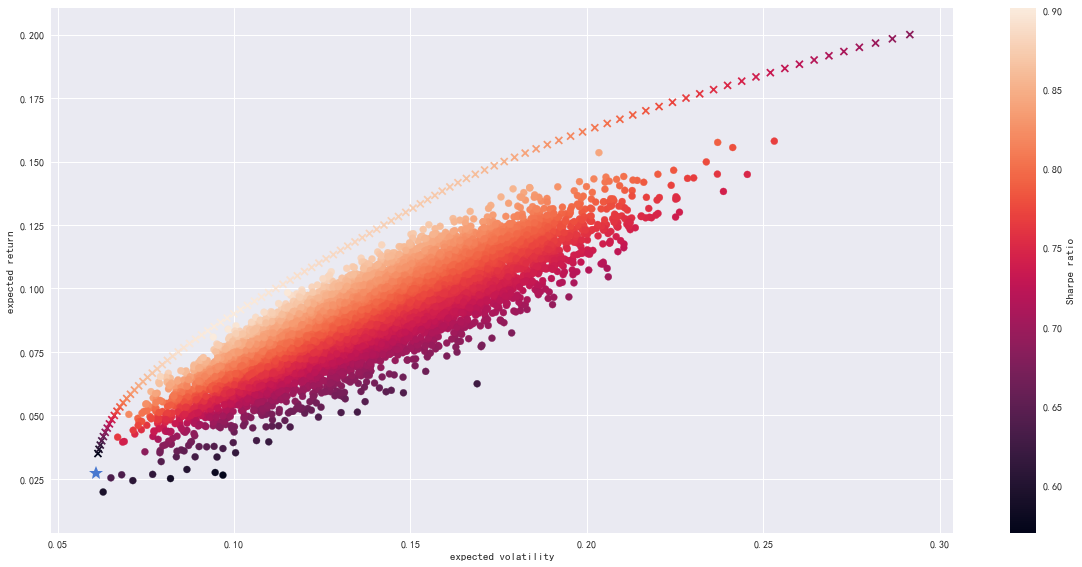

In [20]:
target_returns = np.linspace(0.035, 0.2,100)
target_volatilities = []
def min_func_port(weights):
    # 优化目标函数 -- 最小化波动率
    return statistics(weights)[1]

for tret in target_returns:
    cons = (
            {'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret}, # 给定收益率
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1},           # 权重和为1
            {'type': 'ineq', 'fun': lambda x: x[2]-0.15},              # 纳斯达克不少于15% 
            {'type': 'ineq', 'fun': lambda x: 0.3-x[7]})               # 美国债券不超过30%
    res = sco.minimize(min_func_port, x0, method='SLSQP', bounds=bounds, constraints=cons)
    target_volatilities.append(res['fun'])

fig, axes = plt.subplots(1,1,figsize=(18, 9))
plt.scatter(sds, rtn, c=rtn/sds, marker='o')
#叉叉为有效边界            
plt.scatter(target_volatilities, target_returns, c=target_returns / target_volatilities, marker='x')

#蓝星为最小方差的资产组合            
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0],'b*', markersize=15.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

### 市场投资组合

如果所有投资人对各资产未来收益率的估计是一致的，那么理性投资人持有风险资产相对比例应该是一样的，风险偏好水平不同只会影响持有的无风险资产的比例。从无风险资产收益率出发，与有效前沿相切的切点为市场投资组合。

In [21]:

ind = np.argmin(target_volatilities) # 找到target_volatilities最小值的下标
# 通过下标，可以提取边界上半部分的点的集合
upper_half_volatilities = target_volatilities[ind:]
upper_half_returns = target_returns[ind:]
# 通过差值法获得有效前沿的函数特征
tck = sci.splrep(upper_half_volatilities, upper_half_returns)

#利用tck参数构造有效边界函数f(x)
def f(x):
    return sci.splev(x, tck, der=0)

#同时也构造有效边界函数f(x)的一阶导数函数d_f(x)
def d_f(x):
    return sci.splev(x, tck, der=1)

'''
市场投资线满足如下特征：
1. 它是条直线 t(x) = a+bx
2. t(0) = a a是无风险收益
3. 与有效前沿切点的导数为斜率：dt(x) = b
令
p[0] = a
p[1] = b 
p[2] = x
上面三个约束可以用如下代码表示
'''
def equations(p, risk_free_return=0.035):
    eq1 = risk_free_return - p[0] # p(0) = 无风险收益
    eq2 = risk_free_return + p[1] * p[2] - f(p[2]) # 是一条直线a + b*x
    eq3 = p[1] - d_f(p[2]) # 有效前沿切点的斜率就是直线的斜率, dt(x) = b
    return eq1, eq2, eq3

opt = sco.fsolve(equations, [0.01, 0.50, 0.15])
print(opt)

[ 0.035       0.65332069  0.16779242]


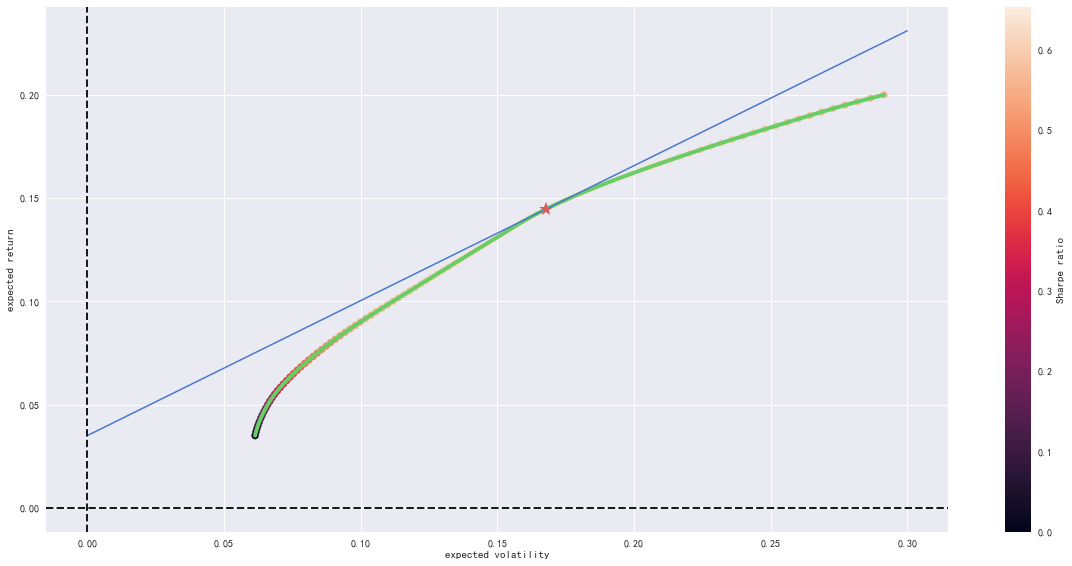

In [64]:
plt.figure(figsize=(18, 9))
#圆点为随机资产组合
plt.scatter(target_volatilities, target_returns, c=(target_returns - 0.035) / target_volatilities, marker='o')
#绿色线为有效边界
plt.plot(upper_half_volatilities, upper_half_returns, 'g', lw=4.0)

#设定资本市场线CML的x范围从0到0.           
cml_x = np.linspace(0.0, 0.3)
#带入公式a+b*x求得y,作图
plt.plot(cml_x, opt[0] + opt[1] * cml_x, lw=1.5)
#标出资本市场线与有效边界的切点，红星处            
plt.plot(opt[2], f(opt[2]), 'r*', markersize=15.0) 
plt.grid(True)
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

In [66]:
def min_func_return(weights):
    # 优化目标函数 -- 最大化收益
    return -statistics(weights)[0]

# 计算市场投资组合各资产的权重
cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[1] - opt[2]}, # 给定方差
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1}) 
market_portfolio = sco.minimize(min_func_return, x0, method='SLSQP', bounds=bounds, constraints=cons)
w = np.array(market_portfolio.x)
print('3年数据投资组合权重')
w

3年数据投资组合权重


array([  0.00000000e+00,   0.00000000e+00,   5.55174547e-01,
         2.61849442e-01,   5.52672057e-17,   1.82976011e-01,
         8.59905730e-17,   6.71210083e-18])

# 三、五年的情况（2011-12-31至2016-12-31），讨论方式与三年类似

### 数据归一化

In [115]:
import pandas as pd
import numpy as np

df = pd.read_csv('5years.csv') # 5years.csv为预处理好的数据
df.drop(['Unnamed: 0'], axis=1, inplace=True)
# print(df.head())
date = df.pop('Date') # 弹出日期列
# print(df.head())
df = df/df.loc[0]*100 # 统一缩放到100为基点
df.head()

GLD      S&P500      NASDAQ        上证指数        深圳成指       创业板指数  \
0  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
1  100.506670  100.018793   99.986409   98.634640   97.501575   96.930775   
2  101.192919  100.313219  100.798121   97.682571   96.428227   91.420151   
3  100.820934  100.058729  100.962729   98.361841   96.811237   91.709390   
4  100.371986  100.285030  101.051074  101.203499  100.305758   94.917066   

         恒生指数        美国债券  
0  100.000000  100.000000  
1   99.204870   99.863674  
2   99.660970  100.000000  
3   98.493702  100.081796  
4   99.938074  100.000000

### 绘制各指数走势

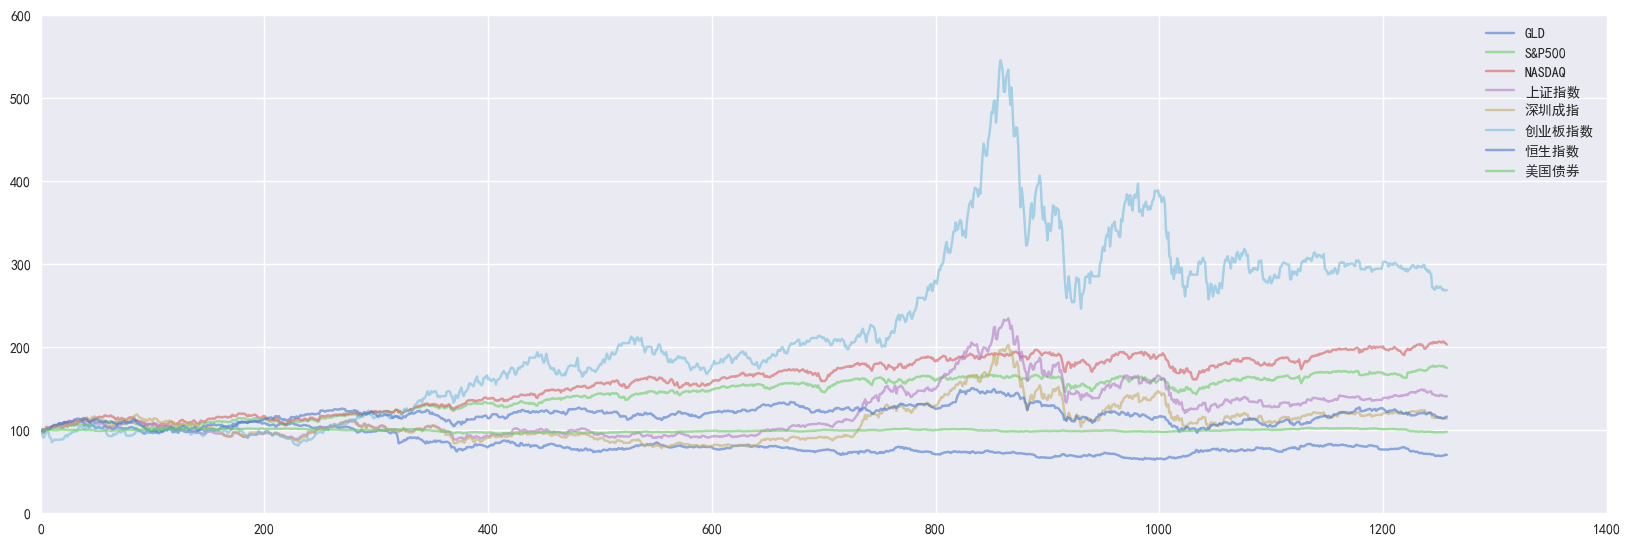

In [116]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette="muted", color_codes=True)
fig, axes = plt.subplots(1,1,figsize=(18, 6))

def plot(data):
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.plot(data, label=data.name, alpha=.6)
    
df.apply(plot)
plt.legend() 
plt.show()

### 计算收益率
Markowitz模型基于资产收益和波动，因此需要将指数价格转换为收益率。这里采用简单收益率：

> $R_{t}=\frac{P_{t}-P_{t-1}}{P_{t-1}}$

In [117]:
returns_df = (df-df.shift(1))/df.shift(1) # 简单收益率
# returns_df = np.log(df/df.shift(1)) # 对数收益率
returns_df.dropna(axis='index', inplace=True) # 删除空数据
returns_df.head()

GLD    S&P500    NASDAQ      上证指数      深圳成指     创业板指数      恒生指数  \
1  0.005067  0.000188 -0.000136 -0.013654 -0.024984 -0.030692 -0.007951   
2  0.006828  0.002944  0.008118 -0.009652 -0.011009 -0.056851  0.004598   
3 -0.003676 -0.002537  0.001633  0.006954  0.003972  0.003164 -0.011712   
4 -0.004453  0.002262  0.000875  0.028890  0.036096  0.034977  0.014665   
5  0.013674  0.008886  0.009692  0.026888  0.037464  0.034704  0.007345   

       美国债券  
1 -0.001363  
2  0.001365  
3  0.000818  
4 -0.000817  
5 -0.000273

### 查看收益率分布直方图

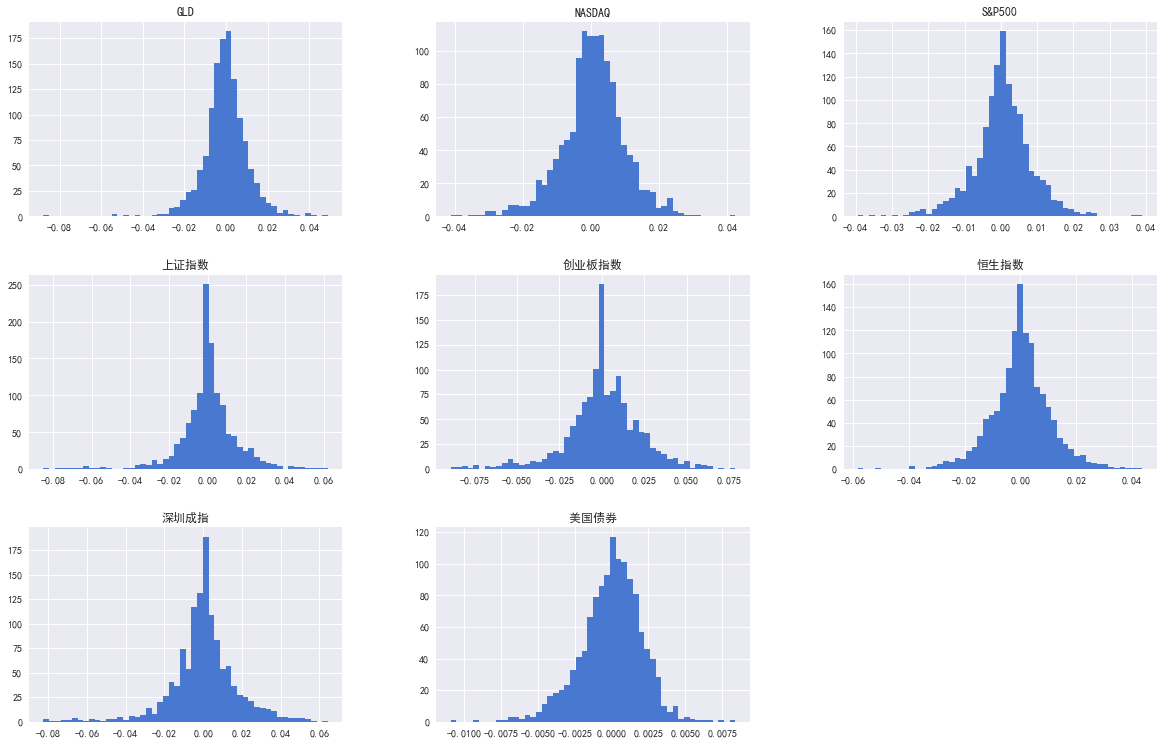

In [103]:
hist = returns_df.hist(bins=50, figsize=(18, 12)) # 查看收益率分布
plt.show()

## 利用Markowitz模型构建投资组合

### 计算年化收益率

年化收益率有两种计算方式：

* 算数平均算法：$年化收益率=\frac{R_{T}}{T}*m$
* 几何平均算法：$年化收益率=[(1+R_{T})^\frac{m}{T}]-1$

In [118]:
year_ret = np.power(1+returns_df.mean(), 250)-1 # 几何年化收益
year_ret

GLD      -0.054877
S&P500    0.127337
NASDAQ    0.164222
上证指数      0.101800
深圳成指      0.067877
创业板指数     0.292242
恒生指数      0.046010
美国债券     -0.003048
dtype: float64

### 标准差
标准差$\sigma = \sqrt{\frac{1}{T}\sum_{t=1}^{T}{(R_{t}-\bar{R})}^2}$

In [119]:
sigma = returns_df.std() * (250**0.5)
sigma

GLD       0.164926
S&P500    0.128139
NASDAQ    0.148342
上证指数      0.237683
深圳成指      0.279764
创业板指数     0.344254
恒生指数      0.170354
美国债券      0.032895
dtype: float64

### 协方差矩阵
组合的收益率 = $\mu_{p}=E(r_{p})=\sum_{i=1}^N{\omega_i}E(r_{i})$

组合的方差 = $\sigma_{p}^2=\sum_{i=1}^N\sum_{j=1}^N{\omega_i}\omega_j\sigma_{ij}$

In [120]:
year_cov = returns_df.cov()*250
year_cov

GLD    S&P500    NASDAQ      上证指数      深圳成指     创业板指数      恒生指数  \
GLD     0.027201 -0.000526 -0.000991  0.000157  0.000236  0.001354 -0.001491   
S&P500 -0.000526  0.016420  0.017724  0.004166  0.004736  0.004778  0.004927   
NASDAQ -0.000991  0.017724  0.022005  0.005146  0.005805  0.006048  0.006086   
上证指数    0.000157  0.004166  0.005146  0.056493  0.061642  0.056477  0.020431   
深圳成指    0.000236  0.004736  0.005805  0.061642  0.078268  0.075266  0.022295   
创业板指数   0.001354  0.004778  0.006048  0.056477  0.075266  0.118511  0.018234   
恒生指数   -0.001491  0.004927  0.006086  0.020431  0.022295  0.018234  0.029021   
美国债券    0.001506 -0.000894 -0.000960 -0.000328 -0.000403 -0.000247 -0.000418   

            美国债券  
GLD     0.001506  
S&P500 -0.000894  
NASDAQ -0.000960  
上证指数   -0.000328  
深圳成指   -0.000403  
创业板指数  -0.000247  
恒生指数   -0.000418  
美国债券    0.001082

### 相关系数
相关系数$\rho_{A,B}=\frac{\sigma_{AB}}{\sigma_{A}\sigma_{B}}$ 

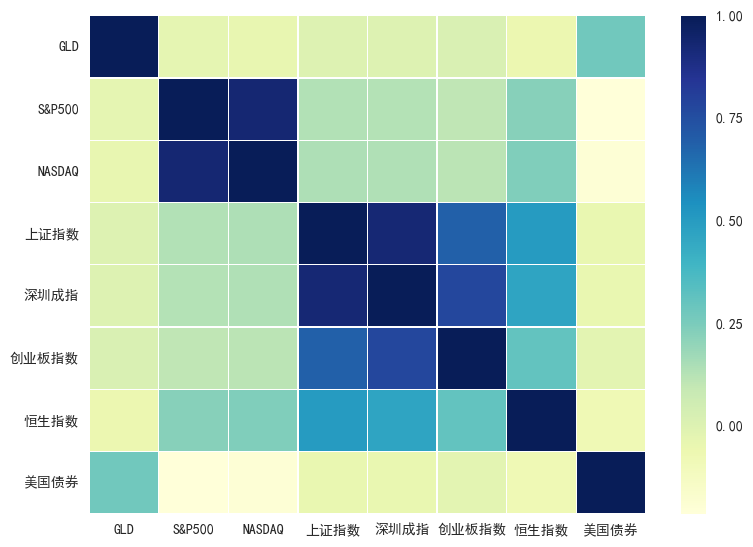

In [122]:
corr = returns_df.corr()
corr_heatmap = sns.heatmap(corr, cmap="YlGnBu", linewidths=.2)
plt.show()

### 计算可行域

组合的收益率 = $\mu_{p}=E(r_{p})=\sum_{i=1}^N{\omega_i}E(r_{i})$

组合的标准差 = $\sigma_{p}^2=\sum_{i=1}^N\sum_{j=1}^N{\omega_i}\omega_j\sigma_{ij}$

将上面的公式向量化，设$\vec{\omega}=\{\omega_{1},\omega_{2},\omega_{3},...\}$，则

> $\mu_{p}= \vec{\omega}^TR$

> $\sigma_{p}^2=\vec{\omega}^TCOV\vec{\omega}$

利用蒙特卡洛模拟，模拟出各种可能权重下组合的收益率和标准差。用描点法，以组合标注差为横轴，以组合收益率为纵轴绘制散点图。

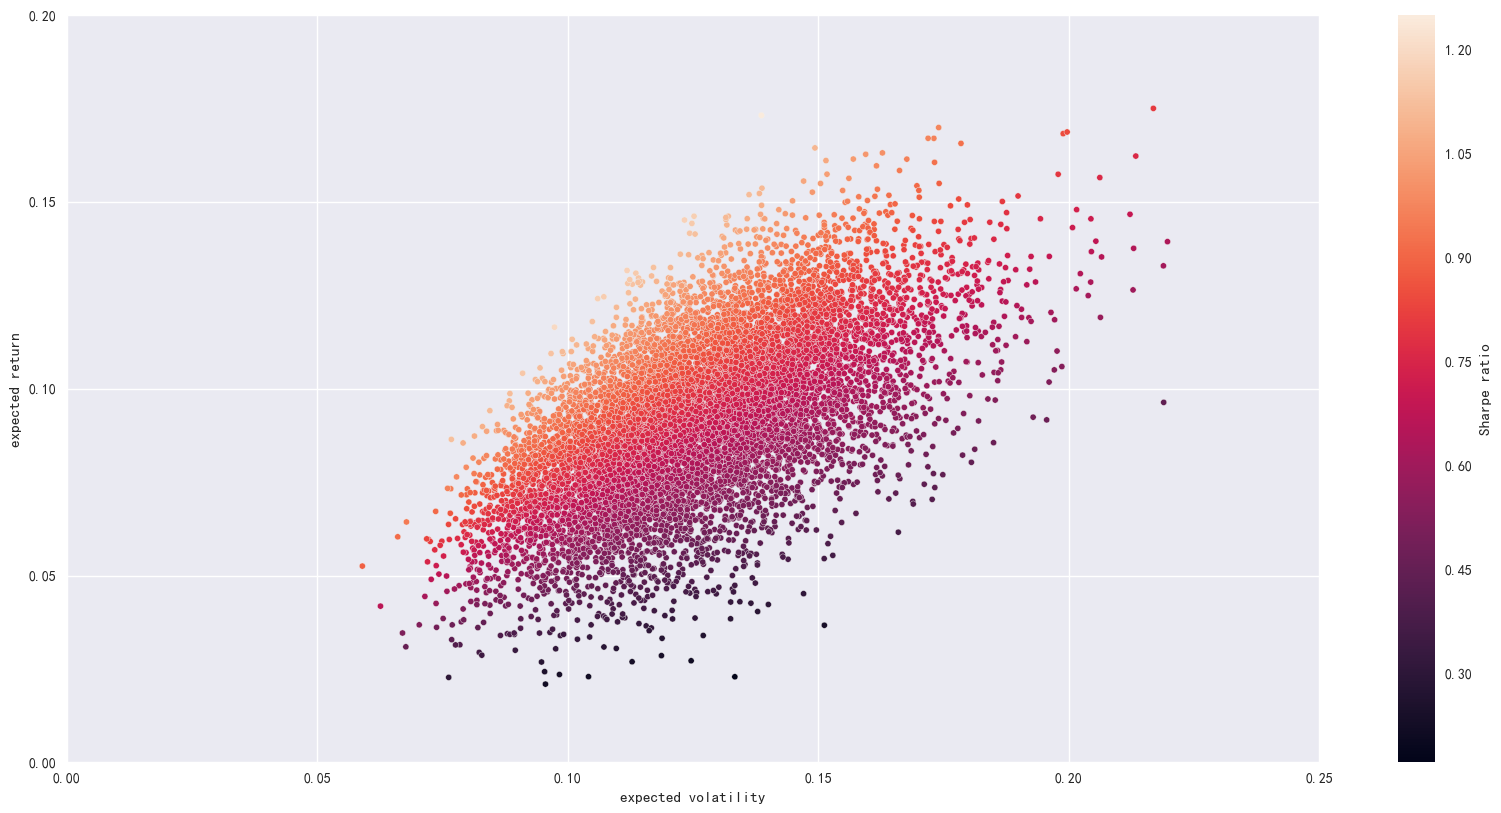

In [123]:
import time
from functools import reduce

sds = [] # 存放各组合标准差
rtn = [] # 存放各组合收益率
num = len(year_ret) # 资产数量
np.random.seed(int(time.time())) # 设置随机数种子

# 模拟1万次
for _ in range(10000):
    w = np.random.rand(num)   # 随机生成各项资产的权重
    w /= sum(w)               # 归一化
    rtn.append(sum(year_ret * w)) # 计算收益率
    sds.append(np.sqrt(reduce(np.dot, [w, year_cov, w.T]))) # 计算波动率
    
sds = np.array(sds)
rtn = np.array(rtn)

# xlim(xmin=0)
# ylim(ymin=0)
fig, axes = plt.subplots(1,1,figsize=(18, 9))
plt.scatter(sds, rtn, c=rtn/sds, marker='o')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

### 绘制有效前沿

有效前沿就是上图中的左边界，它代表同一收益率水平下，风险水平最低的投资组合；或同一风险下，收益最高的组合。可以使用`scipy.optimize`模块中的`minimize`函数来最小化给定收益率水平下的标准差。

#### 标准差最小的组合

In [124]:
import scipy.optimize as sco
import scipy.interpolate as sci

def statistics(w):        
    #根据权重，计算资产组合收益率/波动率/夏普率。
    #输入参数
    #==========
    #weights : array-like 权重数组
    #权重为股票组合中不同股票的权重    
    #返回值
    #=======
    #pret : float
    #      投资组合收益率
    #pvol : float
    #      投资组合波动率
    #pret / pvol : float
    #    夏普率，为组合收益率除以波动率，此处不涉及无风险收益率资产
    #

    w = np.array(w)
    pret = np.sum(year_ret * w)
    pvol = np.sqrt(reduce(np.dot, [w, year_cov, w.T]))
    return np.array([pret, pvol, pret / pvol])

def min_func_sharpe(weights):
    # 优化目标函数 -- 最大化夏普率
    return -statistics(weights)[2]

x0 = np.array([1.0 / num for _ in range(num)]) # 初始权重
bounds = tuple((0, 1) for _ in range(num))     # 取值范围(0,1)，不允许做空

def min_func_variance(weights):
    # 优化目标函数 -- 最小化方差
    # print(weights)
    return statistics(weights)[1] ** 2

# bounds_2 = tuple((0,1) for _ in range(num))
'''
约束条件的类型只有'eq'和'ineq'两种
eq表示约束方程的返回结果为0
ineq表示约束方程的返回结果为非负数
'''
cons_2 = ({'type': 'eq', 'fun': lambda x: sum(x) - 1},     # 权重和为1
    {'type': 'ineq', 'fun': lambda x: x[2]-0.15},          # 纳斯达克不低于15%    
    {'type': 'ineq', 'fun': lambda x: 0.3-x[7]})           # 美国债券不超过30%
optv = sco.minimize(min_func_variance, x0, method='SLSQP', bounds=bounds, constraints=cons_2)
print(optv)


     fun: 0.004326635608006936
     jac: array([ 0.01197586,  0.01149289,  0.0133357 ,  0.01184187,  0.01304071,
        0.01227944,  0.01175405,  0.00059743])
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([ 0.21949644,  0.16238486,  0.15      ,  0.03054133,  0.        ,
        0.        ,  0.13757738,  0.3       ])


### 有效前沿

有效边界实际上就是，有效边界上的每一个点即为给定收益率情况下拥有最小波动率的投资组合的点。所以计算有效边界上的点，可以描述成，已知该点的收益率，求权重组合，使得该点波动率最小。

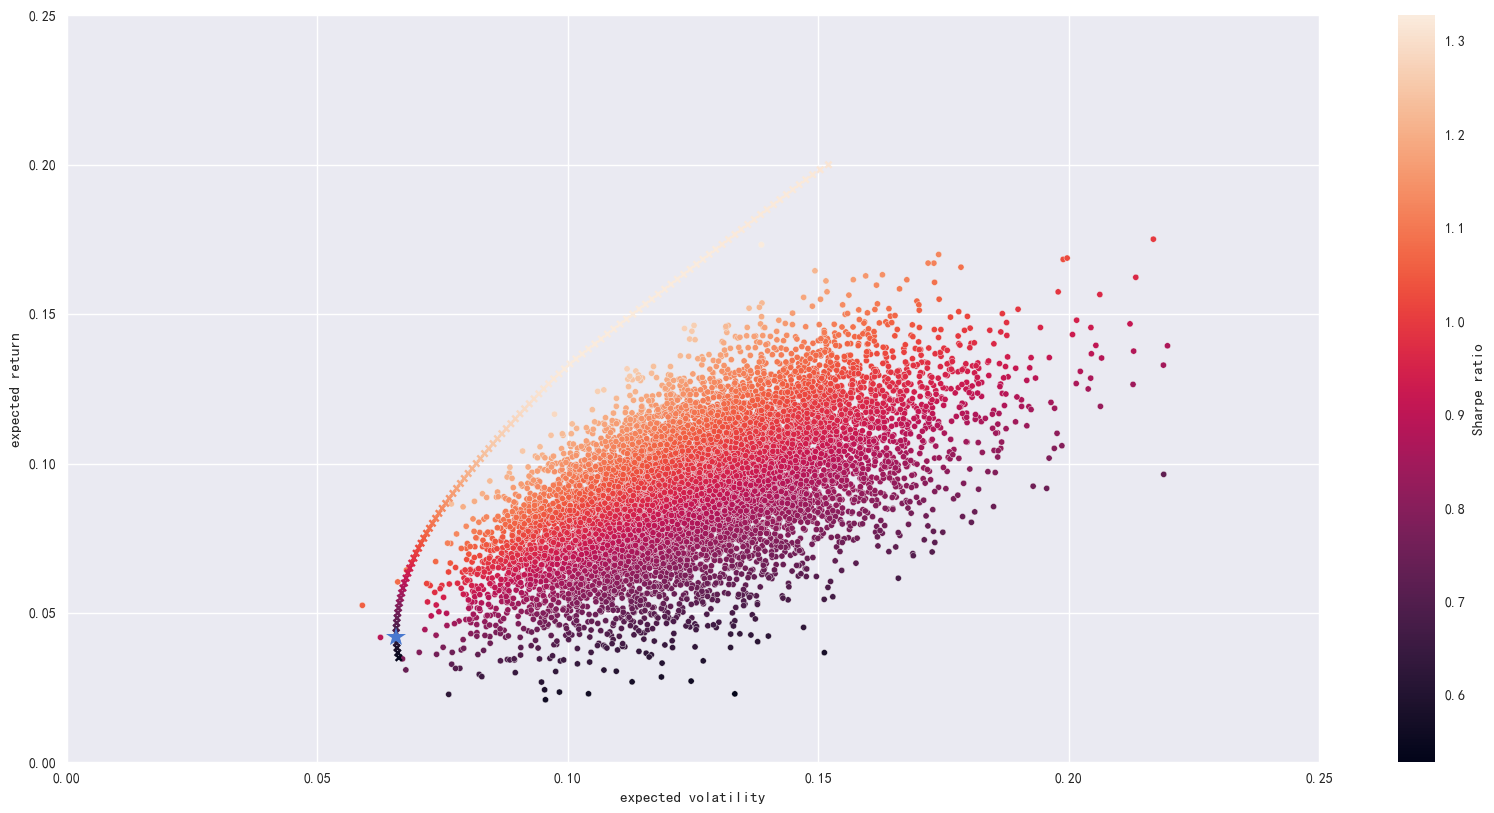

In [125]:
target_returns = np.linspace(0.035, 0.2, 100)
target_volatilities = []
def min_func_port(weights):
    # 优化目标函数 -- 最小化波动率
    return statistics(weights)[1]

for tret in target_returns:
    cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret}, # 给定收益率
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1},           # 权重和为1
            {'type': 'ineq', 'fun': lambda x: x[2]-0.15},              # 纳斯达克不少于15%
            {'type': 'ineq', 'fun': lambda x: 0.3-x[7]})              # 美国债券不超过30%
    res = sco.minimize(min_func_port, x0, method='SLSQP', bounds=bounds, constraints=cons)
    target_volatilities.append(res['fun'])

fig, axes = plt.subplots(1,1,figsize=(18, 9))
plt.scatter(sds, rtn, c=rtn/sds, marker='o')
#叉叉为有效边界            
plt.scatter(target_volatilities, target_returns, c=target_returns / target_volatilities, marker='x')
#红星为夏普率最大值的资产组合            
# plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],'r*', markersize=15.0)
#蓝星为最小方差的资产组合            
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0],'b*', markersize=15.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

### 市场投资组合

如果所有投资人对各资产未来收益率的估计是一致的，那么理性投资人持有风险资产相对比例应该是一样的，风险偏好水平不同只会影响持有的无风险资产的比例。从无风险资产收益率出发，与有效前沿相切的切点为市场投资组合。

In [126]:
ind = np.argmin(target_volatilities) # 找到target_volatilities最小值的下标
# 通过下标，可以提取边界上半部分的点的集合
upper_half_volatilities = target_volatilities[ind:]
upper_half_returns = target_returns[ind:]
# 通过差值法获得有效前沿的函数特征
tck = sci.splrep(upper_half_volatilities, upper_half_returns)

#利用tck参数构造有效边界函数f(x)
def f(x):
    return sci.splev(x, tck, der=0)

#同时也构造有效边界函数f(x)的一阶导数函数d_f(x)
def d_f(x):
    return sci.splev(x, tck, der=1)

'''
市场投资线满足如下特征：
1. 它是条直线 t(x) = a+bx
2. t(0) = a a是无风险收益
3. 与有效前沿切点的导数为斜率：dt(x) = b
令
p[0] = a
p[1] = b 
p[2] = x
上面三个约束可以用如下代码表示
'''
def equations(p, risk_free_return=0.035):
    eq1 = risk_free_return - p[0] # p(0) = 无风险收益
    eq2 = risk_free_return + p[1] * p[2] - f(p[2]) # 是一条直线a + b*x
    eq3 = p[1] - d_f(p[2]) # 有效前沿切点的斜率就是直线的斜率, dt(x) = b
    return eq1, eq2, eq3

opt = sco.fsolve(equations, [0.01, 0.50, 0.15])
print(opt)

[ 0.035       1.08608086  0.1498295 ]


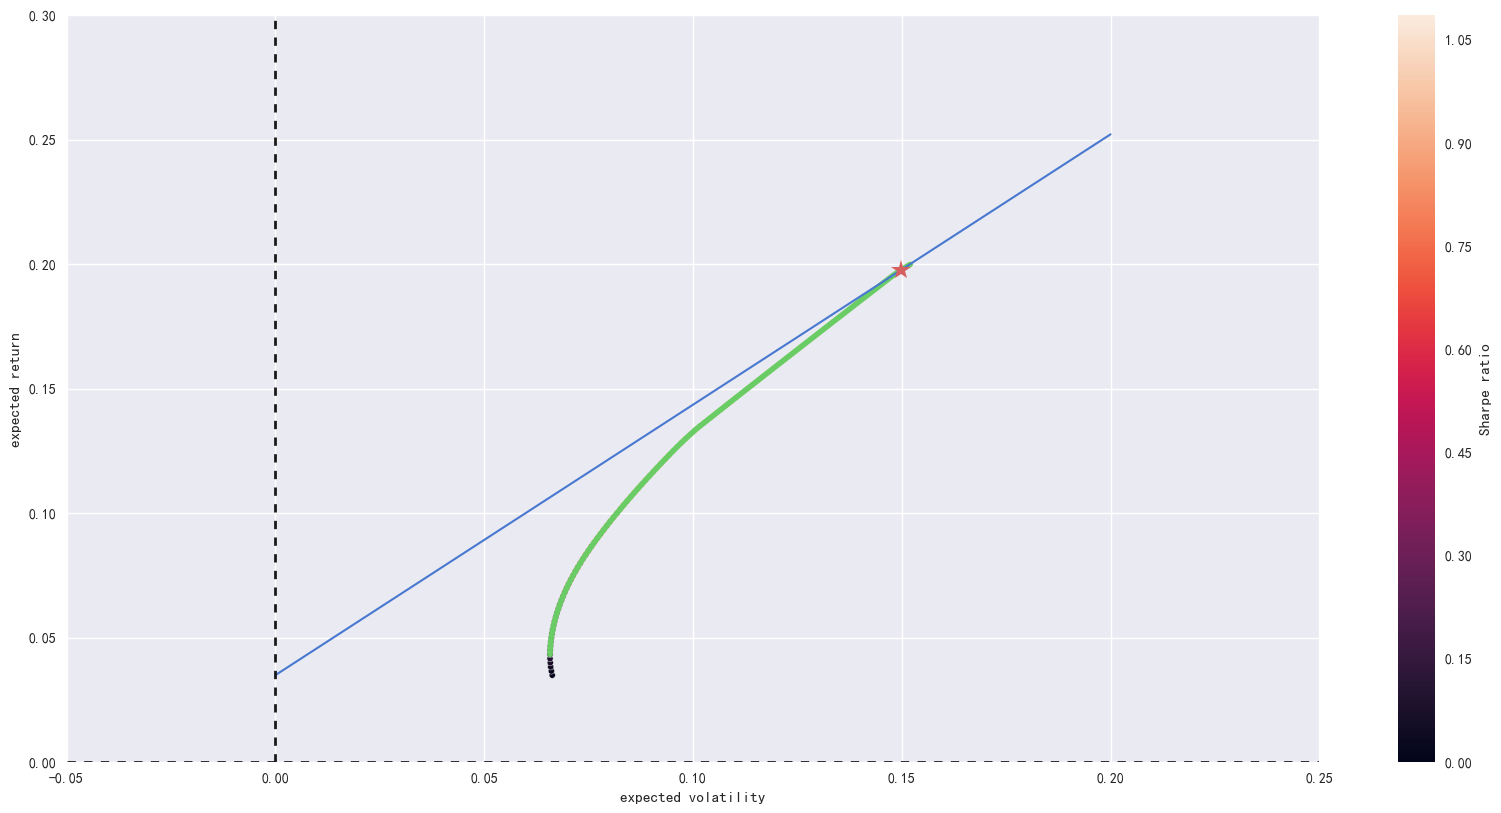

In [127]:
plt.figure(figsize=(18, 9))
#圆点为随机资产组合
plt.scatter(target_volatilities, target_returns, c=(target_returns - 0.035) / target_volatilities, marker='o')
#绿色线为有效边界
plt.plot(upper_half_volatilities, upper_half_returns, 'g', lw=4.0)

#设定资本市场线CML的x范围从0到0.6           
cml_x = np.linspace(0.0, 0.2)
#带入公式a+b*x求得y,作图
plt.plot(cml_x, opt[0] + opt[1] * cml_x, lw=1.5)
#标出资本市场线与有效边界的切点，红星处            
plt.plot(opt[2], f(opt[2]), 'r*', markersize=15.0) 
plt.grid(True)
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

In [128]:
def min_func_return(weights):
    # 优化目标函数 -- 最大化收益
    return -statistics(weights)[0]

# 计算市场投资组合各资产的权重
cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[1] - opt[2]}, # 给定方差
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1}) 
market_portfolio = sco.minimize(min_func_return, x0, method='SLSQP', bounds=bounds, constraints=cons)
w = np.array(market_portfolio.x)
print('5年数据投资组合权重:')
w

5年数据投资组合权重:


array([  1.91022870e-17,   1.03053416e-16,   7.38285504e-01,
         0.00000000e+00,   0.00000000e+00,   2.61714496e-01,
         0.00000000e+00,   0.00000000e+00])

# 四、结论

以下权重顺序为 GLD	S&P500	NASDAQ	上证指数	深圳成指	创业板指数	恒生指数	美国债券

1、3年的情况：以最大化收益来得到资产组合的权重为[  0,   0,   0.555174547, 0.261849442,   5.52672057e-17,   0.182976011,         8.59905730e-17,   6.71210083e-18]

2、5年的情况：权重为[  1.91022870e-17,   1.03053416e-16,  0.738285504, 0, 0,  0.261714496,    0,   0])

3、我们可以发现，在两种情况下：纳斯达克超过0.15,达到了约束的临界值；美国债券为远小于临界值0.3；
  并且，深圳成指和创业板指数权重为0，说明这两种投资方式的收益率波动较大。

4、我们发现这3年的模型，从无风险资产收益率出发，市场投资组合均与有效前沿相切。

# 五、Black-Litterman model

In [129]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False
import datetime
import time
from functools import reduce
from matplotlib import style
style.use('fivethirtyeight')


In [130]:
df = pd.read_csv('5years.csv') # 5years.csv为预处理好的数据
df.drop(['Unnamed: 0'], axis=1, inplace=True)
# print(df.head())
date = df.pop('Date') # 弹出日期列
# print(df.head())
# df = df/df.loc[0]*100 # 统一缩放到100为基点
df.head()

GLD   S&P500   NASDAQ     上证指数     深圳成指   创业板指数      恒生指数    美国债券
0  155.92  1277.06  2648.72  2199.42  8918.82  729.50  18877.41  110.03
1  156.71  1277.30  2648.36  2169.39  8695.99  707.11  18727.31  109.88
2  157.78  1281.06  2669.86  2148.45  8600.26  666.91  18813.41  110.03
3  157.20  1277.81  2674.22  2163.39  8634.42  669.02  18593.06  110.12
4  156.50  1280.70  2676.56  2225.89  8946.09  692.42  18865.72  110.03

In [131]:
returns_df = (df-df.shift(1))/df.shift(1) # 简单收益率
# returns_df = np.log(df/df.shift(1)) # 对数收益率
returns_df.dropna(axis='index', inplace=True) # 删除空数据
returns_df.head()

GLD    S&P500    NASDAQ      上证指数      深圳成指     创业板指数      恒生指数  \
1  0.005067  0.000188 -0.000136 -0.013654 -0.024984 -0.030692 -0.007951   
2  0.006828  0.002944  0.008118 -0.009652 -0.011009 -0.056851  0.004598   
3 -0.003676 -0.002537  0.001633  0.006954  0.003972  0.003164 -0.011712   
4 -0.004453  0.002262  0.000875  0.028890  0.036096  0.034977  0.014665   
5  0.013674  0.008886  0.009692  0.026888  0.037464  0.034704  0.007345   

       美国债券  
1 -0.001363  
2  0.001365  
3  0.000818  
4 -0.000817  
5 -0.000273

## 主观观点


1. 美国市场未来会有较强表现，预计标普收益率12%；
2. 更加看好科技股的未来，预计纳斯达克比标普收益高5%；
3. 黄金会比较波动，预计最终黄金大概率会出现收益持平；
4. 随着中国改革的深化，国内产能将得到逐步优化，加上一带一路的成功和国内企业竞争力的提升，预计中国会有10%的增长；
5. 恒生指数已经到历史高位，上涨动力有限，预计比A股低6%；



In [132]:
P=np.matrix([[ 0, 1, 0, 0, 0, 0, 0, 0],    #标普
            [ 0, -1, 1, 0, 0, 0, 0, 0],    #标普，纳斯达克
            [1, 0, 0, 0, 0, 0, 0, 0],    #黄金
            [ 0, 0, 0,1/3,1/3,1/3, 0, 0], #中国  
            [ 0, 0, 0,1/3,1/3,1/3,-1, 0]]) #中国 恒生

q=np.matrix([ 0.12, 0.05, 0, 0.1, 0.06])
tau = 0.2


先验协方差corvaricance

观点误差的协方差矩阵omega，表示每个观点的信心水平

先验期望收益率pi

In [133]:
corvariance = returns_df.cov()*250     #协方差  8×8
omega = np.diag(np.dot(np.dot(P, (tau*corvariance)),P.T))
omega = np.matrix(np.diag(omega))

In [134]:
pi = np.power(1+returns_df.mean(), 250)-1  #修正前的几何年化收益率
a = (np.matrix(tau*corvariance).I + np.dot(np.dot(P.T, omega.I),P)).I              #miu_BL公式前半部分
b = (np.matrix(tau*corvariance).I*np.matrix(pi).T) + np.dot(np.dot(P.T, omega.I),q.T)    #miu_BL公式后半部分
miu_BL = np.dot(a,b)   #修正后的收益率
miu_BL=np.array(miu_BL)[:,0]
variance_BL = np.array(a+np.matrix(corvariance))        #修正后的协方差矩阵

计算可行域

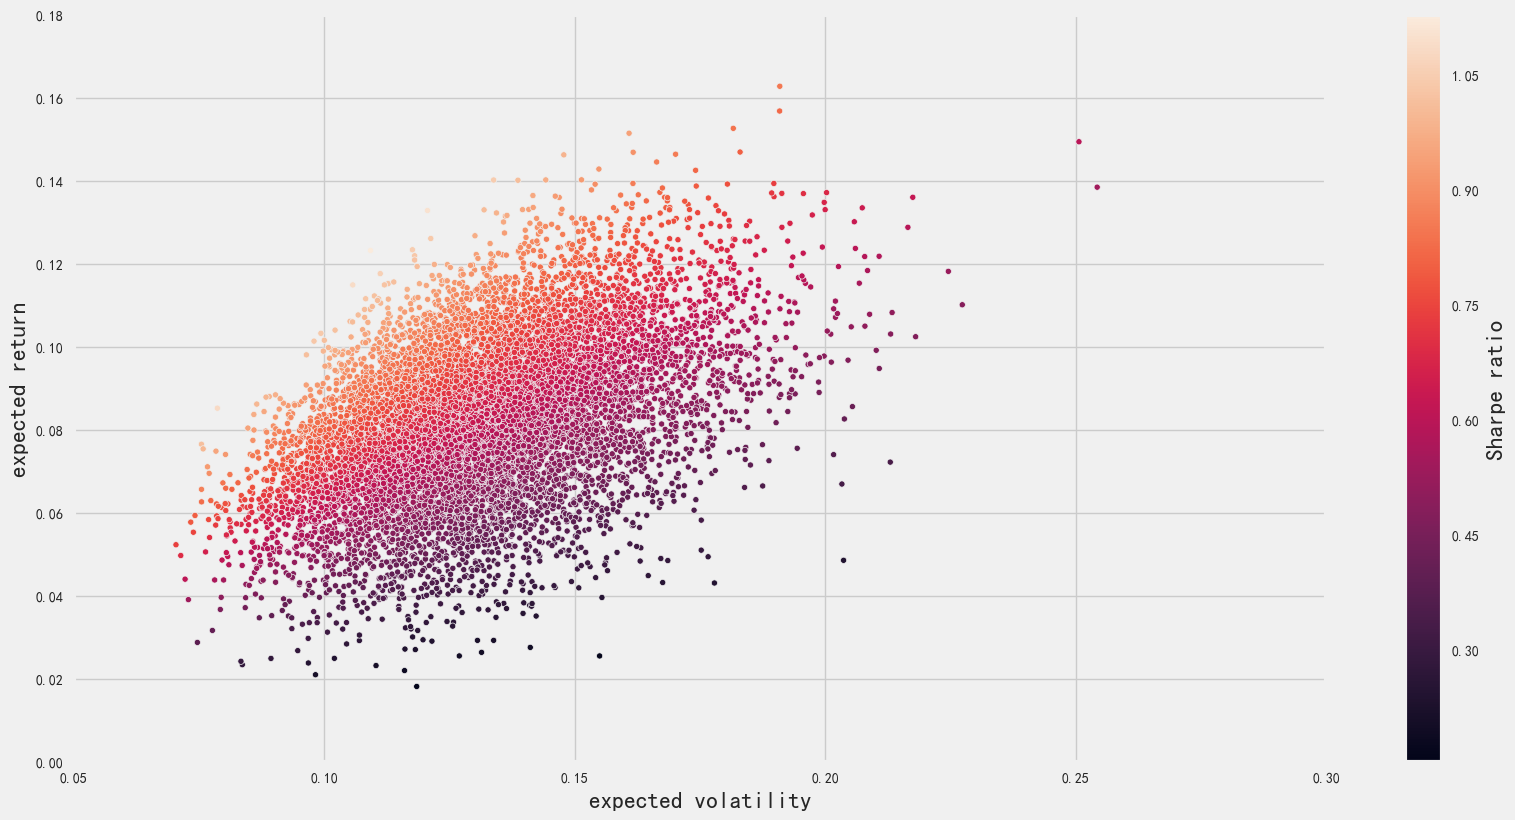

In [135]:
import time

sds = [] # 存放各组合标准差
rtn = [] # 存放各组合收益率
num = len(miu_BL) # 资产数量
np.random.seed(int(time.time())) # 设置随机数种子

# 模拟1万次
for _ in range(10000):
    w = np.random.rand(num)   # 随机生成各项资产的权重
    w /= sum(w)               # 归一化
    rtn.append(sum(miu_BL * w)) # 计算收益率
    sds.append(np.sqrt(reduce(np.dot, [w, variance_BL, w.T]))) # 计算波动率
    
sds = np.array(sds)
rtn = np.array(rtn)

# xlim(xmin=0)
# ylim(ymin=0)
fig, axes = plt.subplots(1,1,figsize=(18, 9))
plt.scatter(sds, rtn, c=rtn/sds, marker='o')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

绘制有效前沿

In [136]:
import scipy.optimize as sco
import scipy.interpolate as sci

def statistics(w):        
    #根据权重，计算资产组合收益率/波动率/夏普率。
    #输入参数
    #==========
    #weights : array-like 权重数组
    #权重为股票组合中不同股票的权重    
    #返回值
    #=======
    #pret : float
    #      投资组合收益率
    #pvol : float
    #      投资组合波动率
    #pret / pvol : float
    #    夏普率，为组合收益率除以波动率，此处不涉及无风险收益率资产
    #

    w = np.array(w)
    pret = np.sum(miu_BL * w)
    pvol = np.sqrt(reduce(np.dot, [w, variance_BL, w.T]))
    return np.array([pret, pvol, pret / pvol])


x0 = np.array([1.0 / num for _ in range(num)]) # 初始权重
bounds = tuple((0, 1) for _ in range(num))     # 取值范围(0,1)，不允许做空
constraints = [{'type': 'eq', 'fun': lambda x: sum(x) - 1}] # 约束条件，权重之和等于1
cons_2 = ({'type': 'eq', 'fun': lambda x: sum(x) - 1})     # 权重和为1
#     {'type': 'ineq', 'fun': lambda x: x[2]-0.15},          # 纳斯达克不低于15%    
#     {'type': 'ineq', 'fun': lambda x: 0.3-x[7]})           # 美国债券不超过30%


最小标准差组合

In [137]:
# 用'SLSQP'（Sequential Least Squares Programming）方法寻找最优解
def min_func_variance(weights):
    # 优化目标函数 -- 最小化标准差
    return statistics(weights)[1] 

optv = sco.minimize(min_func_variance, x0, method='SLSQP',  bounds=bounds, constraints=cons_2)
print (optv)


     fun: 0.03191397049466105
     jac: array([ 0.04256903,  0.03209728,  0.03545565,  0.03185848,  0.03370396,
        0.03388953,  0.03237907,  0.03188172])
 message: 'Optimization terminated successfully.'
    nfev: 110
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([ 0.        ,  0.0960194 ,  0.        ,  0.00572107,  0.        ,
        0.        ,  0.02349481,  0.87476472])


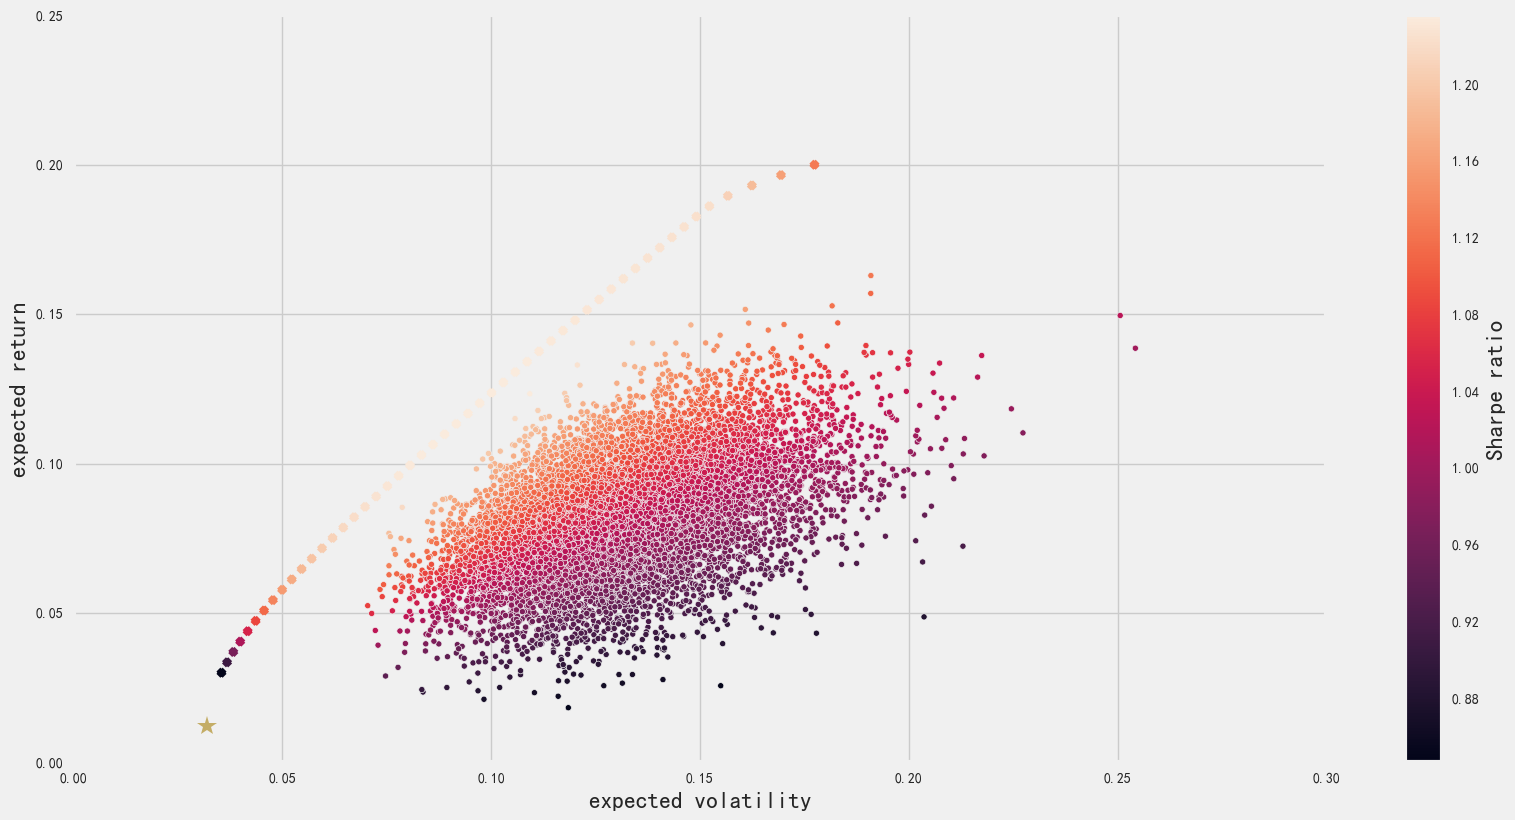

In [138]:
target_returns = np.linspace(0.03, 0.2, 50)
target_volatilities = []

def min_func_port(weights):
    # 优化目标函数 -- 最小化波动率
    return statistics(weights)[1]
for tret in target_returns:
    cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret}, # 给定收益率
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})           # 权重和为1
    
    res = sco.minimize(min_func_port, x0, method='SLSQP', bounds=bounds, constraints=cons)
    target_volatilities.append(res['fun'])
fig, axes = plt.subplots(1,1,figsize=(18, 9))
plt.scatter(sds, rtn, c=rtn/sds, marker='o')
#叉叉为有效边界            
plt.scatter(target_volatilities, target_returns, c=target_returns / target_volatilities, marker='x')
# 红星为夏普率最大值的资产组合            
# plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],'r*', markersize=15.0)
#黄星为最小方差的资产组合            
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0],'y*', markersize=15.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

In [139]:
ind = np.argmin(target_volatilities) # 找到target_volatilities最小值的下标
# 通过下标，可以提取边界上半部分的点的集合
upper_half_volatilities = target_volatilities[ind:]
upper_half_returns = target_returns[ind:]
# 通过差值法获得有效前沿的函数特征
tck = sci.splrep(upper_half_volatilities, upper_half_returns)

#利用tck参数构造有效边界函数f(x)
def f(x):
    return sci.splev(x, tck, der=0)

#同时也构造有效边界函数f(x)的一阶导数函数d_f(x)
def d_f(x):
    return sci.splev(x, tck, der=1)

'''
市场投资线满足如下特征：
1. 它是条直线 t(x) = a+bx
2. t(0) = a a是无风险收益
3. 与有效前沿切点的导数为斜率：dt(x) = b
令
p[0] = a
p[1] = b 
p[2] = x
上面三个约束可以用如下代码表示
'''
def equations(p, risk_free_return=0.035):
    eq1 = risk_free_return - p[0] # p(0) = 无风险收益
    eq2 = risk_free_return + p[1] * p[2] - f(p[2]) # 是一条直线a + b*x
    eq3 = p[1] - d_f(p[2]) # 有效前沿切点的斜率就是直线的斜率, dt(x) = b
    return eq1, eq2, eq3

opt = sco.fsolve(equations, [0.01, 0.50, 0.15])
print(opt)

[ 0.035       0.99252145  0.15214433]


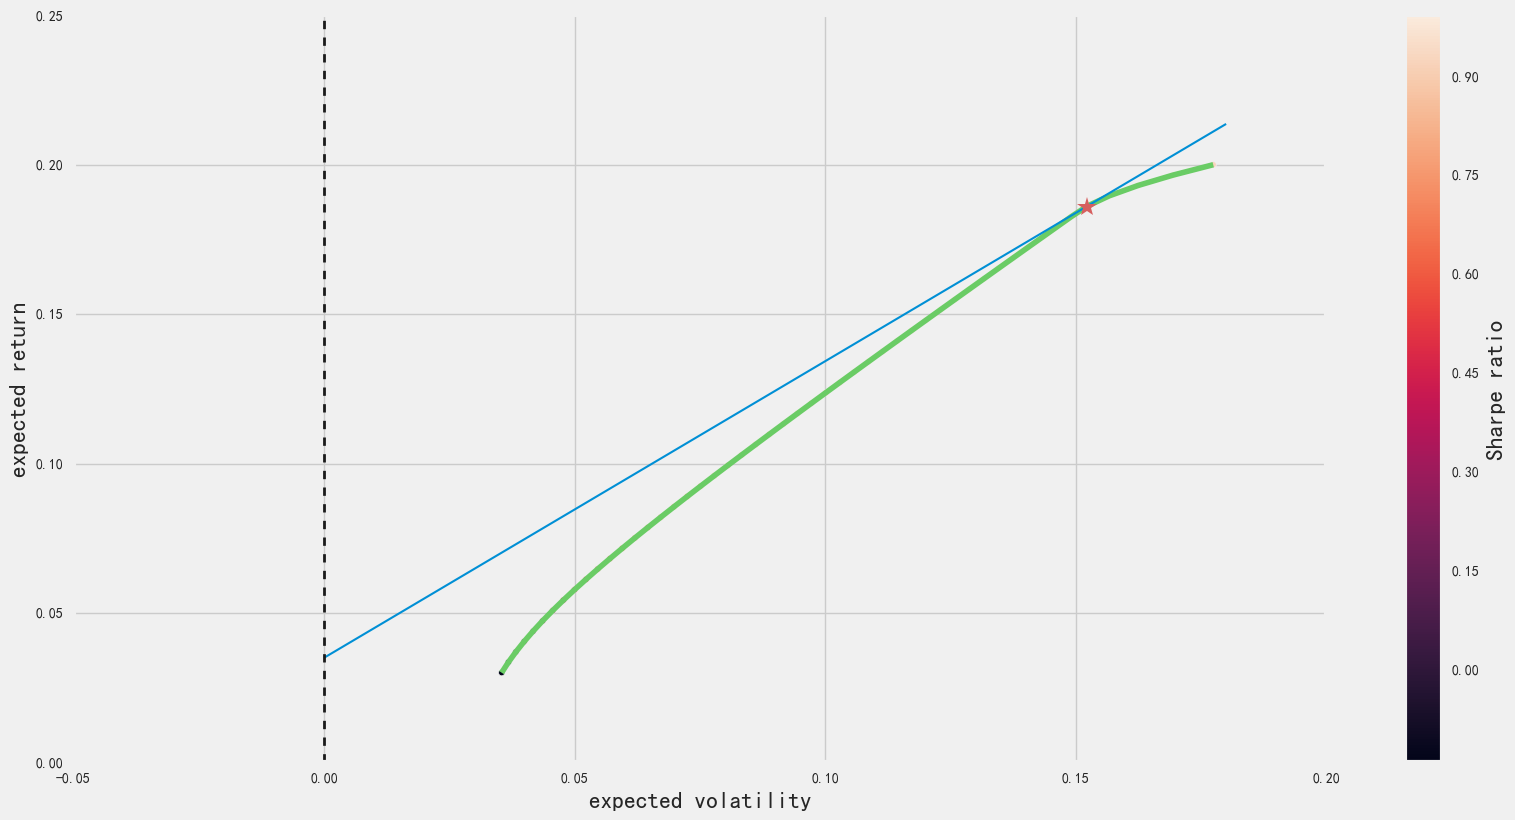

In [140]:
plt.figure(figsize=(18, 9))
#圆点为随机资产组合
plt.scatter(target_volatilities, target_returns, c=(target_returns - 0.035) / target_volatilities, marker='o')
#绿色线为有效边界
plt.plot(upper_half_volatilities, upper_half_returns, 'g', lw=4.0)

#设定资本市场线CML的x范围从0到0.18          
cml_x = np.linspace(0.0, 0.18)
#带入公式a+b*x求得y,作图
plt.plot(cml_x, opt[0] + opt[1] * cml_x, lw=1.5)
#标出资本市场线与有效边界的切点，红星处            
plt.plot(opt[2], f(opt[2]), 'r*', markersize=15.0) 
plt.grid(True)
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

### VaR

In [141]:
def min_func_return(weights):
    # 优化目标函数 -- 最大化收益
    return -statistics(weights)[0]

# 计算市场投资组合各资产的权重
cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[1] - opt[2]}, # 给定方差
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1}) 
market_portfolio = sco.minimize(min_func_return, x0, method='SLSQP', bounds=bounds, constraints=cons)
w = np.array(market_portfolio.x)
print('BL模型投资组合权重')
w

BL模型投资组合权重


array([  0.00000000e+00,   0.00000000e+00,   7.78482946e-01,
         0.00000000e+00,   6.64412644e-17,   2.21517054e-01,
         1.91666615e-17,   6.07280272e-17])

以下权重顺序为 GLD	S&P500	NASDAQ	上证指数	深圳成指	创业板指数	恒生指数	美国债券

1、Markowitz模型5年的情况：权重为[  1.91022870e-17,   1.03053416e-16,  0.738285504, 0, 0,  0.261714496,    0,   0])

2、Black-Litterman模型5年的情况：权重为[ 0,0, 0.778482946, 0,6.64412644e-17, 0.221517054, 1.91666615e-17,   6.07280272e-17]

# 比较模型差异
我们发现二者的权重差异不大，下面我们比较以下他们的各自回撤表现


In [142]:
import pandas as pd
df1 = pd.read_csv('并集指数.csv',engine='python',encoding = 'utf8')
close = df1[(df1['Date'] >= '2017-01-01') & (df1['Date'] <= '2017-12-31')].drop('Date',axis=1)

import numpy as np
close = pd.DataFrame(close,dtype=np.float)
close = close.reset_index(drop=True)

#归一化
close = close / close.loc[0] * 100 

In [143]:
'''
计算收益率
'''
returns_df1 = (close-close.shift(1))/close.shift(1) # 简单收益率
returns_df1.dropna(axis='index', inplace=True) # 删除空数据
returns_df1.head()

GLD    S&P500    NASDAQ      上证指数      深圳成指     创业板指数      恒生指数  \
1  0.003530  0.005722  0.008828  0.007293  0.011889  0.014420 -0.000719   
2  0.015515 -0.000771  0.001996  0.002096 -0.001290 -0.003816  0.014557   
3 -0.007373  0.003517  0.006035 -0.003503 -0.007917 -0.009547  0.002063   
4  0.008233 -0.003549  0.001949  0.005364  0.004124 -0.001735  0.002474   
5  0.004260  0.000000  0.003615 -0.003018 -0.002463 -0.005067  0.008252   

       美国债券  
1  0.000277  
2  0.004159  
3 -0.003313  
4  0.001662  
5 -0.000277

In [144]:
year_cov1 = returns_df1.cov()*250
year_ret1 = np.power(1+returns_df1.mean(), 250)-1 # 几何年化收益
year_ret1

GLD       0.124725
S&P500    0.186743
NASDAQ    0.277345
上证指数      0.058434
深圳成指      0.085577
创业板指数    -0.095661
恒生指数      0.356262
美国债券      0.011136
dtype: float64

In [145]:
#协方差阵
sigma1 = returns_df1.std() * (250**0.5)
def rateandstd(weight):
    rate = np.sum(year_ret1 * weight)
    std = np.sqrt(reduce(np.dot, [weight, year_cov1, weight.T]))
    print('收益率{:.4f}%'.format(rate*100),'标准差{:.6f}'.format(std))


In [146]:
# 计算回撤
def draw_down(ret, t):
    tmp_max = 0
    tmp_index = 0
    for i in range(t):
        if ret[i]-ret[t] > tmp_max:
            tmp_max = ret[i]-ret[t]
            tmp_index = i
    return tmp_max, tmp_index

# 计算最大回撤
def max_draw_down(ret):
    tmp_max = 0;
    dd_index_start = 0;
    dd_index_end = 0;
    for i in range(len(ret)):
        dd, dd_index = draw_down(ret, i)
        if dd > tmp_max:
            tmp_max = dd
            dd_index_end = i
            dd_index_start = dd_index
    return tmp_max, dd_index_start, dd_index_end

## 5年数据拟合的Markowitz模型所得投资组合权重，测试在2017年的表现

In [147]:
from functools import reduce
w1 = np.array([ 1.91022870e-17, 1.03053416e-16, 0.738285504, 0, 0, 0.261714496, 0, 0])
rateandstd(w1)

收益率17.9724% 标准差0.080974


## 5年数据拟合的Black-Litterman模型所得投资组合权重，测试2017年的表现

In [148]:
w0 = np.array([ 0, 0, 0.778482946, 0, 2.02474756e-17, 0.221517054, 8.36190926e-18, 0])
rateandstd(w0)

收益率19.4718% 标准差0.081421


# 结论

以下权重顺序为 GLD	S&P500	NASDAQ	上证指数	深圳成指	创业板指数	恒生指数	美国债券

用5年数据和Markowitz模型构建的资产组合（下记为组合1）的权重为
[ 1.91022870e-17, 1.03053416e-16, 0.738285504, 0, 0, 0.261714496, 0, 0]，在17年数据上的表现: 
收益率为17.9724%，标准差为0.080974。

用5年数据和Black-Litterman模型构建的资产组合（下记为组合2）的权重为[ 0, 0, 0.778482946, 0, 2.02474756e-17, 0.221517054, 8.36190926e-18, 0]，在17年数据上的表现: 收益率为19.4718%，标准差为0.081421。

组合1的收益率为小于组合2的收益率。虽然组合1的标准差稍微低一点,主要差异来源于纳斯达克和中国创业板的权重不同

最大回撤-2.28%，发生区间(225, 233)


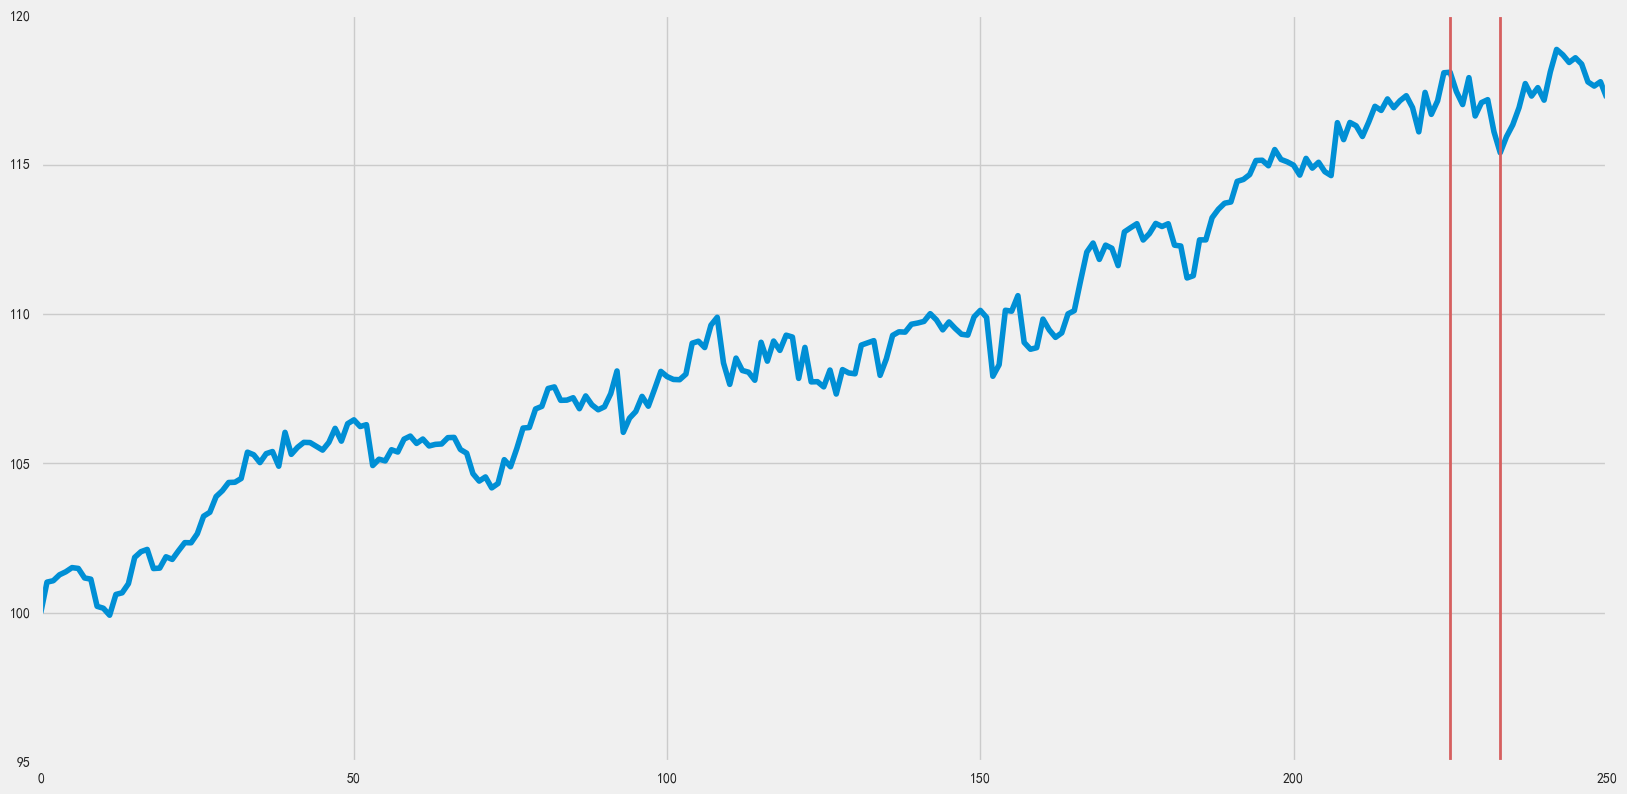

In [149]:
weight = np.array( [ 1.91022870e-17, 1.03053416e-16, 0.738285504, 0, 0, 0.261714496, 0, 0])
portfolio_value = [np.dot(weight.T,close.loc[i]) for i in range(251)]
ddm, start, end = max_draw_down(portfolio_value)
ddm = -ddm*100/portfolio_value[start]
print('最大回撤{:.2f}%，发生区间({}, {})'.format(ddm, start, end))

# 可视化最大回撤
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1,1,figsize=(18, 9))
plt.plot(portfolio_value)
plt.axvline(x=start,linewidth=2,color="r")
plt.axvline(x=end,linewidth=2,color="r")
plt.show()

最大回撤-2.55%，发生区间(108, 127)


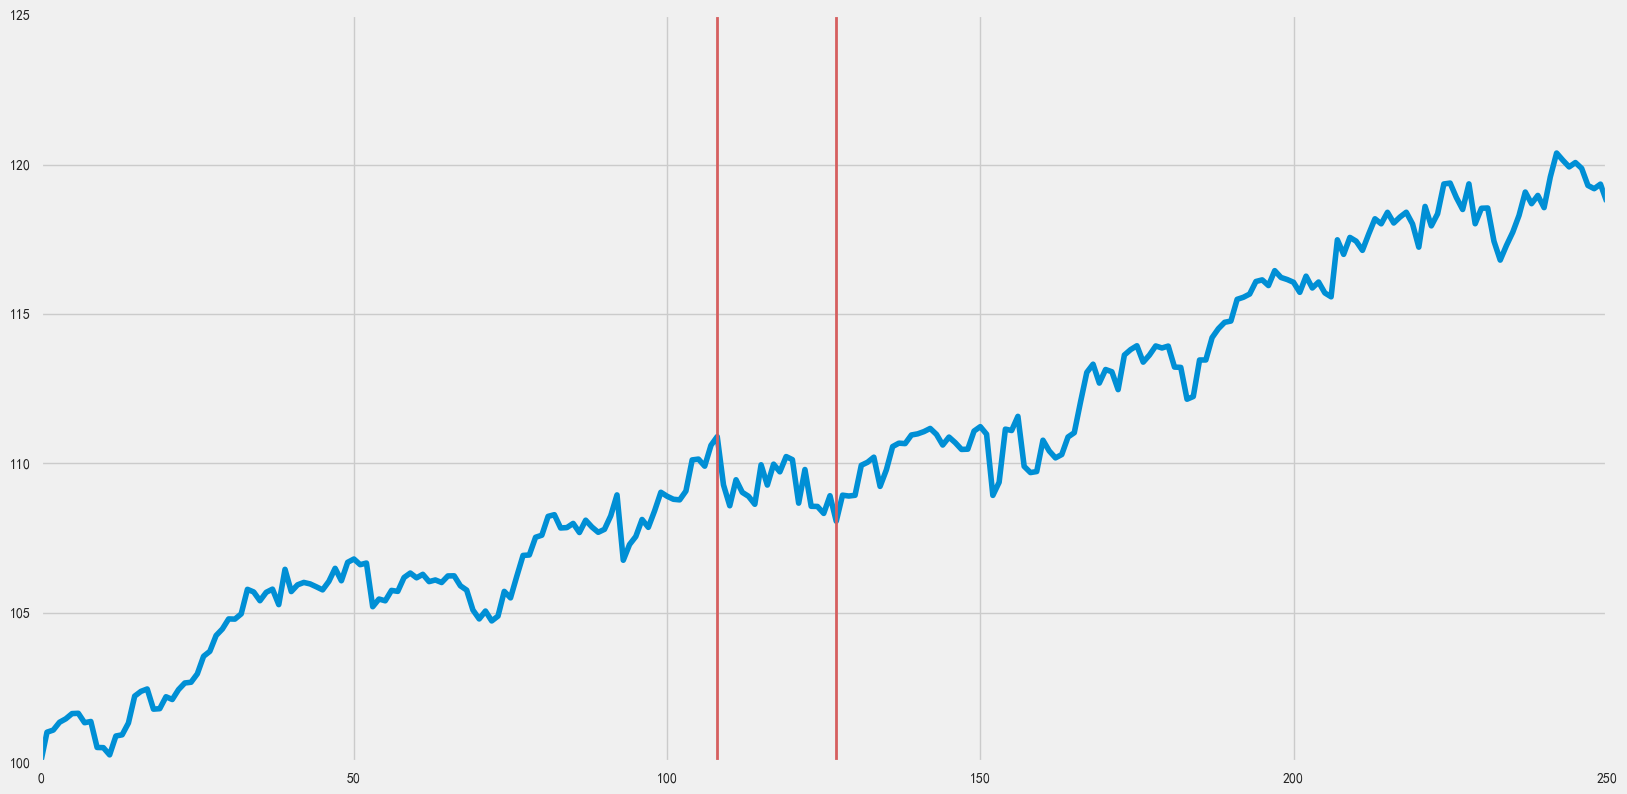

In [150]:
weight = np.array([ 0, 0, 0.778482946, 0, 2.02474756e-17, 0.221517054, 8.36190926e-18, 0])
portfolio_value = [np.dot(weight.T,close.loc[i]) for i in range(251)]
ddm, start, end = max_draw_down(portfolio_value)
ddm = -ddm*100/portfolio_value[start]
print('最大回撤{:.2f}%，发生区间({}, {})'.format(ddm, start, end))

# 可视化最大回撤
fig, axes = plt.subplots(1,1,figsize=(18, 9))
plt.plot(portfolio_value)
plt.axvline(x=start,linewidth=2,color="r")
plt.axvline(x=end,linewidth=2,color="r")
plt.show()

# 作为基金经理，你将如何评价最终的结果？

1.从两个组合的收益率和标准差上看，组合1的收益率17.9724%低于组合2收益率19.4717%，尽管组合1的标准差0.080974要小于组合2的标准差0.081421，但二者标准差差距不大，综合来看组合2的效果要更好。

2.最大回撤率用来恒定投资后可能出现的最坏情况，组合1的最大回撤为2.28%，要小于组合2的最大回撤2.55%，即用最大回撤来衡量，组合1的风险更小一点。

# 历史上的波动走势

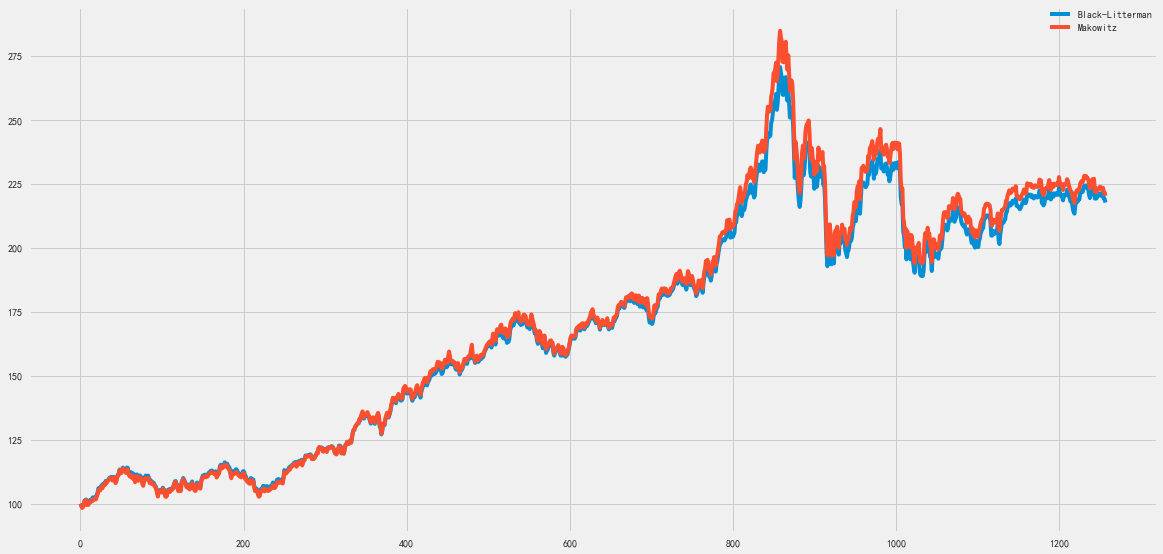

In [182]:
import matplotlib.pyplot as plt  
w1 = np.array([ 1.91022870e-17, 1.03053416e-16, 0.738285504, 0, 0, 0.261714496, 0, 0])
w2 = np.array([ 0, 0, 0.778482946, 0, 2.02474756e-17, 0.221517054, 8.36190926e-18, 0])

portfolio_value1 = np.dot(df, w1) # 计算组合1历史收益
portfolio_value2 = np.dot(df, w2) # 计算组合2历史收益

fig,ax = plt.subplots(figsize=(18, 9))  
  
plt.plot(portfolio_value2,"+-",label="Black-Litterman") 
plt.plot(portfolio_value1,"x-",label="Makowitz")  
"""open the grid"""  
plt.grid(True)  
plt.legend(bbox_to_anchor=(1.0, 1), loc=1, borderaxespad=0.)  
plt.show()  

# 优化模型一

In [151]:
import pandas as pd
import numpy as np
returns = pd.read_csv('D:\\研一课\\风险管理\\马尔可夫机制转换模型\\returns.csv',sep = ',',encoding = 'utf8')

In [152]:
returns.head()

Date       GLD    S&P500    NASDAQ      上证指数      深圳成指     创业板指数  \
0  2012-01-04  0.005067  0.000188 -0.000136 -0.013654 -0.024984 -0.030692   
1  2012-01-05  0.006828  0.002944  0.008118 -0.009652 -0.011009 -0.056851   
2  2012-01-06 -0.003676 -0.002537  0.001633  0.006954  0.003972  0.003164   
3  2012-01-09 -0.004453  0.002262  0.000875  0.028890  0.036096  0.034977   
4  2012-01-10  0.013674  0.008886  0.009692  0.026888  0.037464  0.034704   

       恒生指数      美国债券  
0 -0.007951 -0.001363  
1  0.004598  0.001365  
2 -0.011712  0.000818  
3  0.014665 -0.000817  
4  0.007345 -0.000273

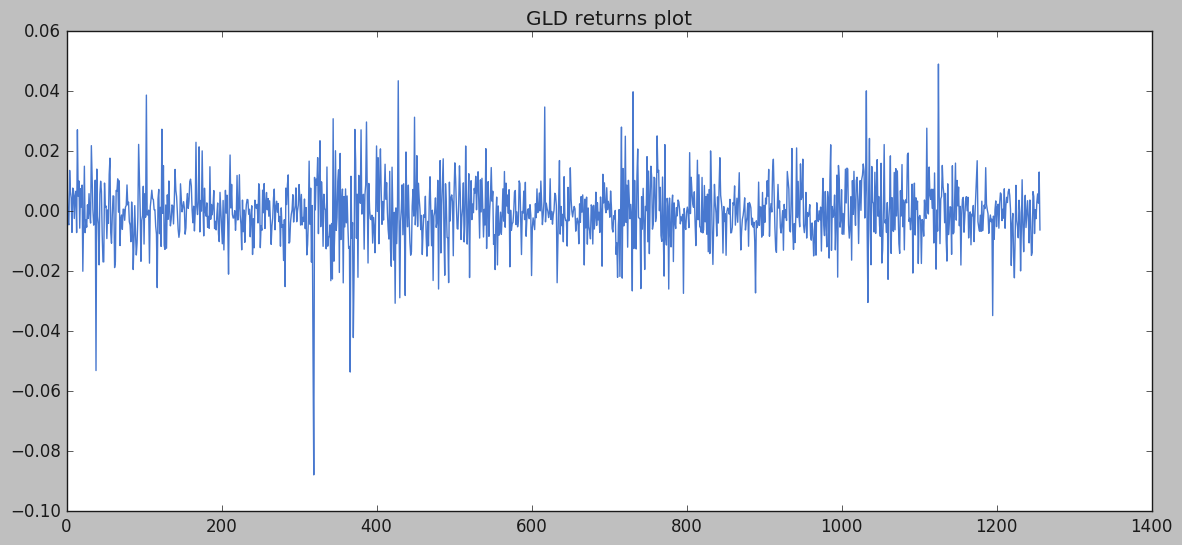

In [153]:
import matplotlib.pyplot as plt
plt.style.use('classic')
plt.figure(figsize = (14,6))
returns.GLD.plot()
plt.title('GLD returns plot')
plt.show()

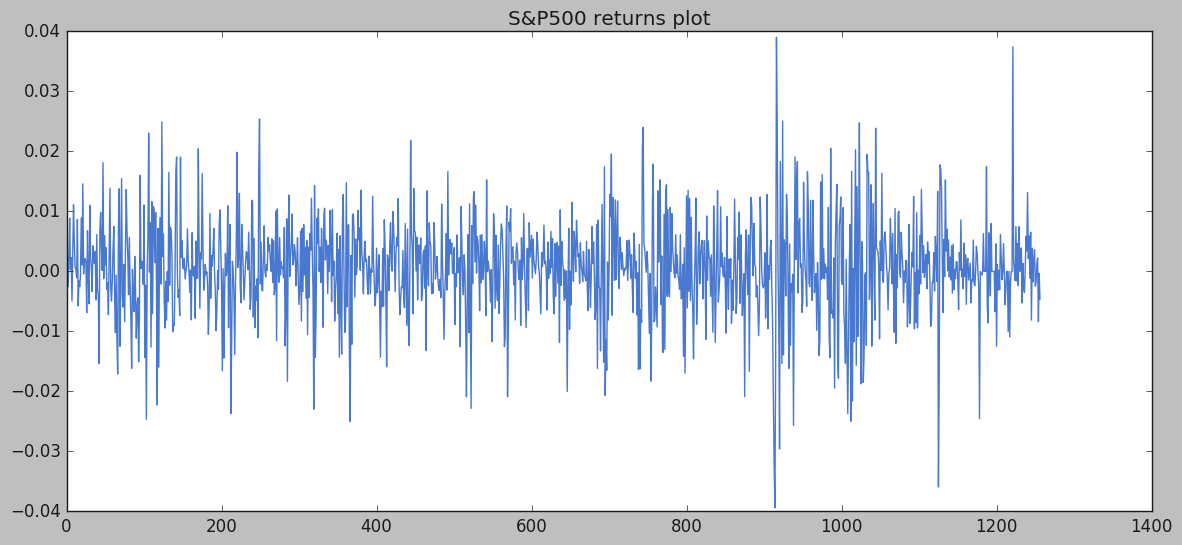

In [154]:
plt.figure(figsize = (14,6))
returns['S&P500'].plot()
plt.title('S&P500 returns plot')
plt.show()

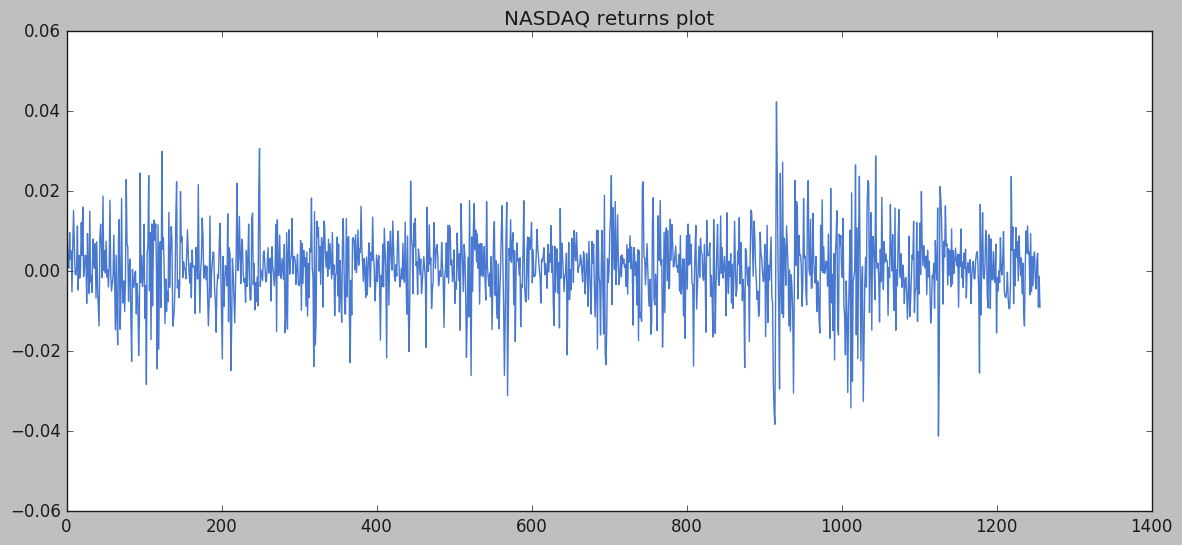

In [155]:
plt.figure(figsize = (14,6))
returns.NASDAQ.plot()
plt.title('NASDAQ returns plot')
plt.show()

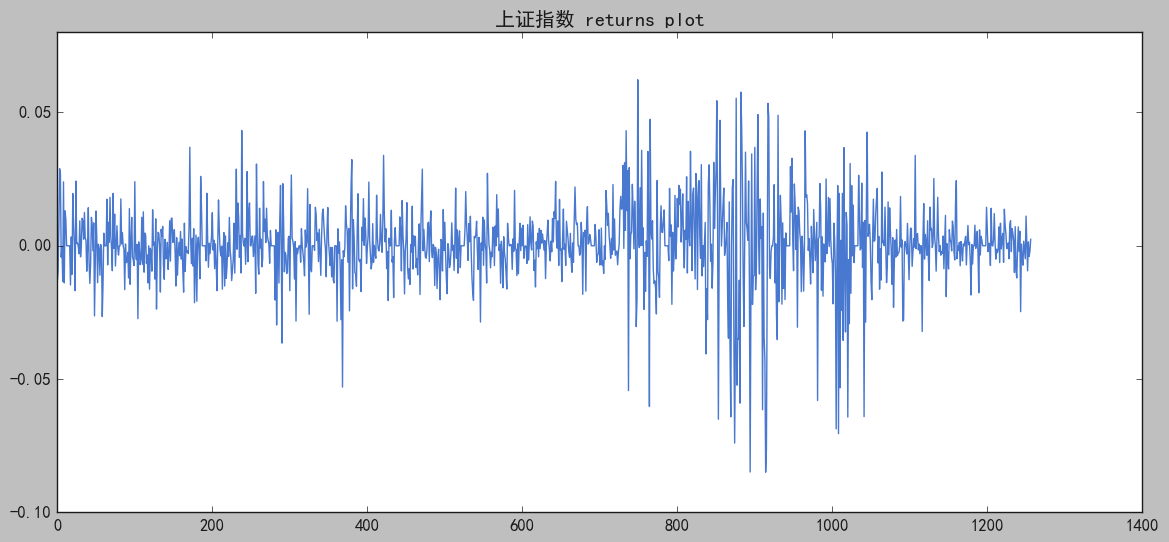

In [156]:
plt.figure(figsize = (14,6))
returns.上证指数.plot()
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.title('上证指数 returns plot')
plt.show()

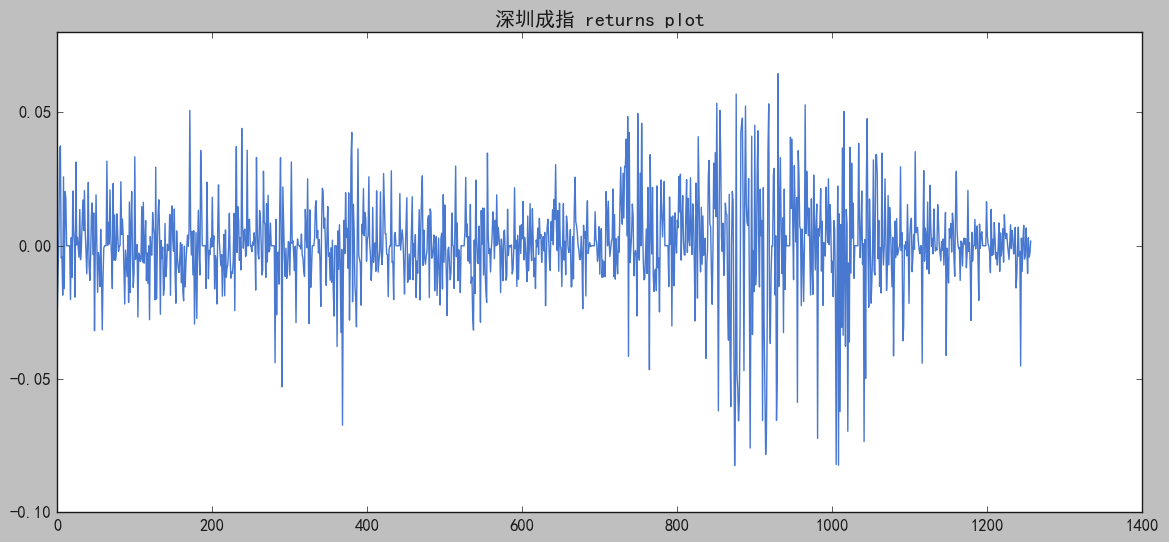

In [157]:
plt.figure(figsize = (14,6))
returns.深圳成指.plot()
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.title('深圳成指 returns plot')
plt.show()

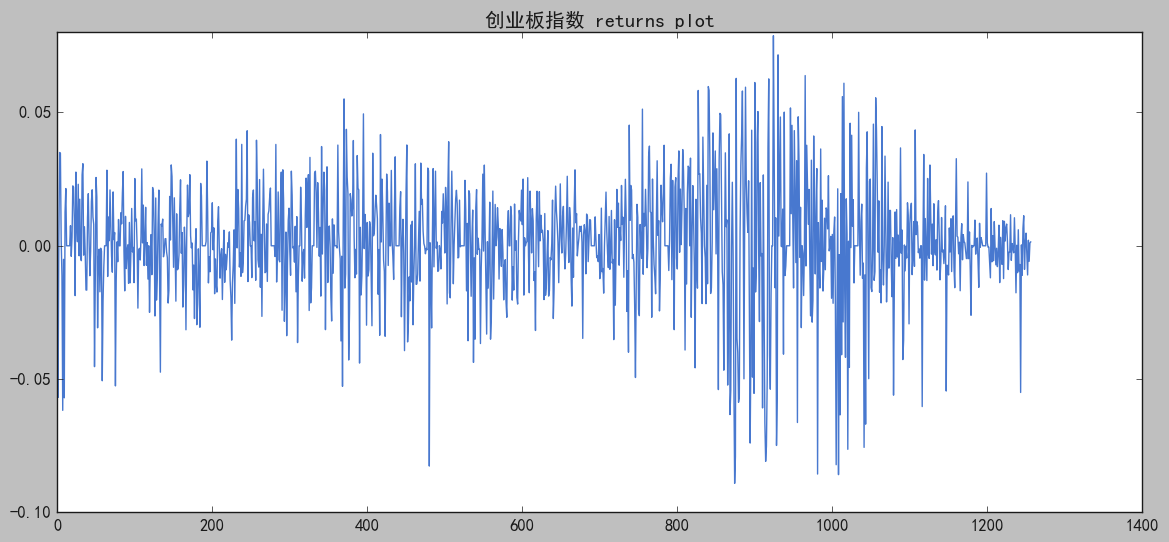

In [158]:
plt.figure(figsize = (14,6))
returns.创业板指数.plot()
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.title('创业板指数 returns plot')
plt.show()

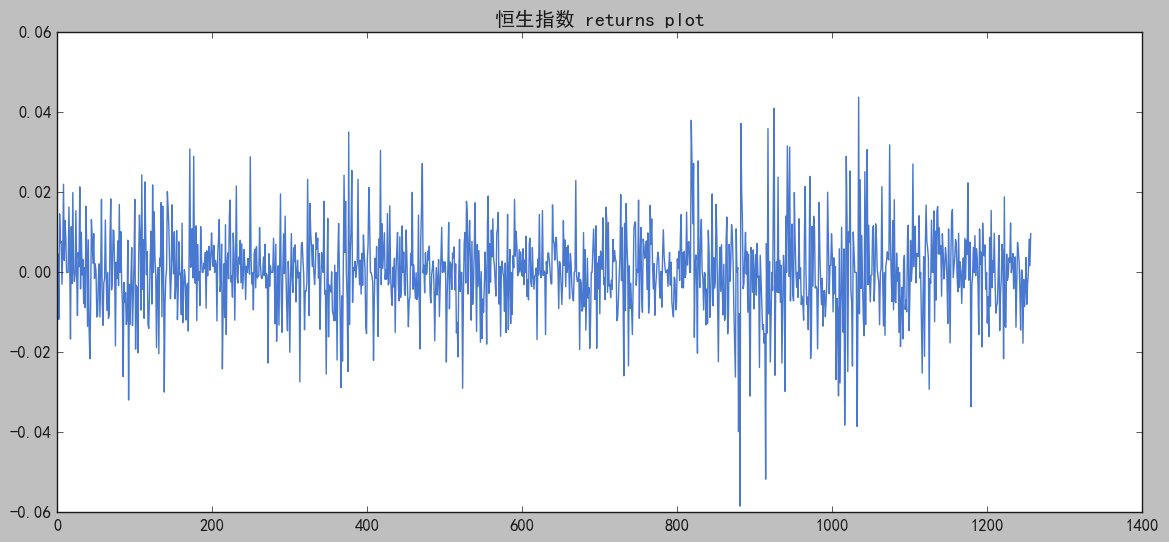

In [159]:
plt.figure(figsize = (14,6))
returns.恒生指数.plot()
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.title('恒生指数 returns plot')
plt.show()

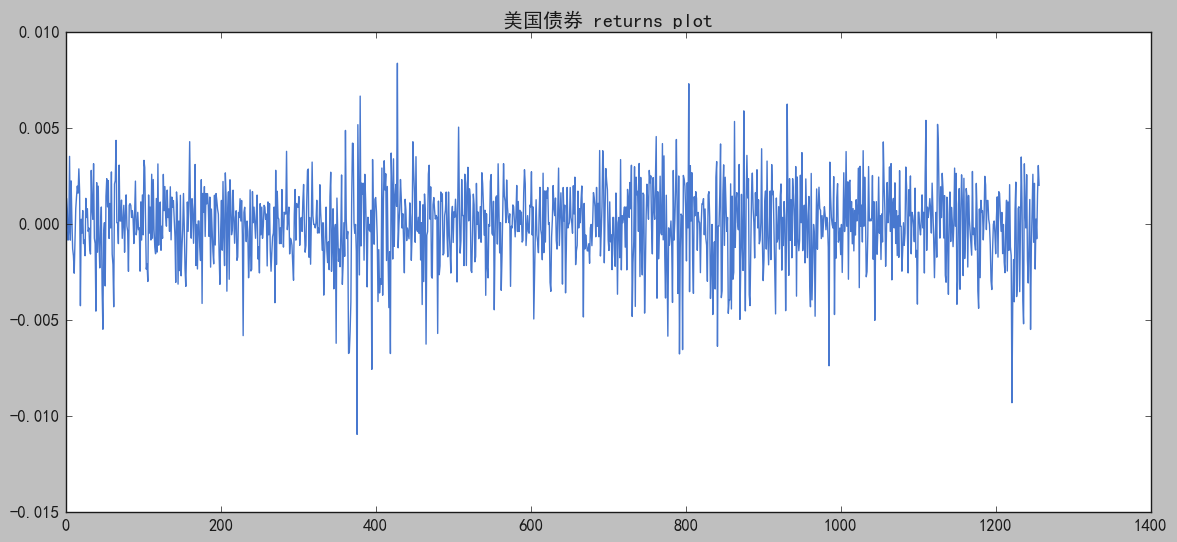

In [160]:
plt.figure(figsize = (14,6))
returns.美国债券.plot()
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.title('美国债券 returns plot')
plt.show()

### 由上面的时间序列图可以看出，8个资产都存在波动聚集性

# Markove Regime Switching GARCH-M model
由R代码使用马尔可夫机制转换GARCH-M模型拟合5年历史收益率，并预测出2017年各个资产的波动率，

具体代码见附件的.R文件，结果保存在pred_volatility.csv中，读取如下所示

In [6]:
import pandas as pd
import numpy as np
pred_volatility = pd.read_csv(r'C:\Users\corem\Documents\终稿\pred_volatility.csv',sep = ',',encoding = 'utf8' )
pred_volatility.pop('Unnamed: 0')
pred_volatility

index_name    GLD_fit  GLD_pred    GLD_sample     SP_fit   SP_pred  \
0        sum  12.793094  2.518658  1.366560e-01  10.001553  2.452076   
1       mean   0.010177  0.010075  1.087160e-04   0.007957  0.009808   
2        max   0.037504  0.010650  7.670700e-03   0.031677  0.011608   
3        min   0.008050  0.008961  2.266751e-10   0.005072  0.007065   
4     median   0.009669  0.010130  2.790612e-05   0.006919  0.009858   

      SP_sample  NASDAQ_fit  NASDAQ_pred  NASDAQ_sample       ...        \
0  8.249164e-02   11.390573     2.426653   1.105547e-01       ...         
1  6.562581e-05    0.009062     0.009707   8.795121e-05       ...         
2  1.591469e-03    0.028093     0.010160   1.746071e-03       ...         
3  4.593997e-11    0.006198     0.008560   1.970745e-11       ...         
4  1.748981e-05    0.008191     0.009731   2.494271e-05       ...         

      SZ_sample    GEM_fit  GEM_pred    GEM_sample     HK_fit   HK_pred  \
0  3.932185e-01  26.171839  4.838317  5.953997e-01  13.158016  2.590689   
1  3.128230e-04   0.020821  0.019353  4.736673e-04   0.010468  0.010363   
2  6.839374e-03   0.048823  0.021175  8.122228e-03   0.021636  0.010660   
3  2.597619e-10   0.010986  0.013539  4.223086e-12   0.007943  0.009469   
4  5.474060e-05   0.018678  0.020194  1.129523e-04   0.010083  0.010397   

      HK_sample  America_fit  America_pred  America_sample  
0  1.457995e-01     2.388845      0.455648    5.436437e-03  
1  1.159901e-04     0.001900      0.001823    4.324930e-06  
2  3.432511e-03     0.002980      0.002108    1.192759e-04  
3  1.530375e-10     0.001572      0.001731    1.490504e-10  
4  3.073908e-05     0.001828      0.001794    1.614802e-06  

[5 rows x 25 columns]

上表中fit：拟合的5年波动率； <table>

pred：预测的2017年波动率； <table>
sample：样本的5年波动率；<table>
sum：波动率求和；<table>
mean：波动率均值；<table>
max：波动率极大值；<table>
min：波动率极小值；<table>
median：波动率中位数。
### 以下如非说明，皆指波动率
###  因为 $\frac{fit}{sample}=\frac{pred}{test}$ 
### 所以 $test = \frac{pred*sample}{fit}$
### 设 2017年收益率为: $test-returns$，
### 因为 $\frac{sample}{sample-returns}=\frac{test}{test-returns}$
### 所以 $test-returns = \frac{test*sample-returns}{sample} = \frac{pred*sample-returns}{fit}$

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv(r'C:\Users\corem\Documents\终稿\5years.csv') # 5years.csv为预处理好的数据
df.drop(['Unnamed: 0'], axis=1, inplace=True)
# print(df.head())
date = df.pop('Date') # 弹出日期列
# print(df.head())
df = df/df.loc[0]*100 # 统一缩放到100为基点
df.head()

GLD      S&P500      NASDAQ        上证指数        深圳成指       创业板指数  \
0  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
1  100.506670  100.018793   99.986409   98.634640   97.501575   96.930775   
2  101.192919  100.313219  100.798121   97.682571   96.428227   91.420151   
3  100.820934  100.058729  100.962729   98.361841   96.811237   91.709390   
4  100.371986  100.285030  101.051074  101.203499  100.305758   94.917066   

         恒生指数        美国债券  
0  100.000000  100.000000  
1   99.204870   99.863674  
2   99.660970  100.000000  
3   98.493702  100.081796  
4   99.938074  100.000000

In [4]:
returns_df = (df-df.shift(1))/df.shift(1) # 简单收益率
# returns_df = np.log(df/df.shift(1)) # 对数收益率
returns_df.dropna(axis='index', inplace=True) # 删除空数据
returns_df.head()

GLD    S&P500    NASDAQ      上证指数      深圳成指     创业板指数      恒生指数  \
1  0.005067  0.000188 -0.000136 -0.013654 -0.024984 -0.030692 -0.007951   
2  0.006828  0.002944  0.008118 -0.009652 -0.011009 -0.056851  0.004598   
3 -0.003676 -0.002537  0.001633  0.006954  0.003972  0.003164 -0.011712   
4 -0.004453  0.002262  0.000875  0.028890  0.036096  0.034977  0.014665   
5  0.013674  0.008886  0.009692  0.026888  0.037464  0.034704  0.007345   

       美国债券  
1 -0.001363  
2  0.001365  
3  0.000818  
4 -0.000817  
5 -0.000273

In [5]:
#2011~2016年年化收益率
year_ret = np.power(1+returns_df.mean(), 250)-1 # 几何年化收益
year_ret

GLD      -0.054877
S&P500    0.127337
NASDAQ    0.164222
上证指数      0.101800
深圳成指      0.067877
创业板指数     0.292242
恒生指数      0.046010
美国债券     -0.003048
dtype: float64

In [7]:
print('预测2017年GLD年化收益率：{:.4f}%,'.format(pred_volatility.GLD_pred[1]*year_ret.GLD/pred_volatility.GLD_fit[1]*100),
      '平均波动率:{:.6f}，'.format(pred_volatility.GLD_pred[1]*pred_volatility.GLD_sample[1]/pred_volatility.GLD_fit[1]),
      '波动率中位数:{:.6f}'.format(pred_volatility.GLD_pred[4]*pred_volatility.GLD_sample[4]/pred_volatility.GLD_fit[4]))
print('预测2017年S&P500年化收益率：{:.4f}%,'.format(pred_volatility.SP_pred[1]*year_ret[1]/pred_volatility.SP_fit[1]*100),
      '平均波动率:{:.6f}'.format(pred_volatility.SP_pred[1]*pred_volatility.SP_sample[1]/pred_volatility.SP_fit[1]),
     '波动率中位数:{:.6f}'.format(pred_volatility.SP_pred[4]*pred_volatility.SP_sample[4]/pred_volatility.SP_fit[4]))
print('预测2017年NASDAQ年化收益率：{:.4f}%,'.format(pred_volatility.NASDAQ_pred[1]*year_ret.NASDAQ/pred_volatility.NASDAQ_fit[1]*100),
      '平均波动率:{:.6f}，'.format(pred_volatility.NASDAQ_pred[1]*pred_volatility.NASDAQ_sample[1]/pred_volatility.NASDAQ_fit[1]),
      '波动率中位数:{:.6f}'.format(pred_volatility.NASDAQ_pred[4]*pred_volatility.NASDAQ_sample[4]/pred_volatility.NASDAQ_fit[4]))
print('预测2017年上证指数年化收益率：{:.4f}%,'.format(pred_volatility.A_pred[1]*year_ret.上证指数/pred_volatility.A_fit[1]*100),
      '平均波动率:{:.6f}，'.format(pred_volatility.A_pred[1]*pred_volatility.A_sample[1]/pred_volatility.A_fit[1]),
      '波动率中位数:{:.6f}'.format(pred_volatility.A_pred[4]*pred_volatility.A_sample[4]/pred_volatility.A_fit[4]))
print('预测2017年深圳成指年化收益率：{:.4f}%,'.format(pred_volatility.SZ_pred[1]*year_ret.深圳成指/pred_volatility.SZ_fit[1]*100),
      '平均波动率:{:.6f}，'.format(pred_volatility.SZ_pred[1]*pred_volatility.SZ_sample[1]/pred_volatility.SZ_fit[1]),
      '波动率中位数:{:.6f}'.format(pred_volatility.SZ_pred[4]*pred_volatility.SZ_sample[4]/pred_volatility.SZ_fit[4]))
print('预测2017年创业板指数年化收益率：{:.4f}%,'.format(pred_volatility.GEM_pred[1]*year_ret.创业板指数/pred_volatility.GEM_fit[1]*100),
      '平均波动率:{:.6f}，'.format(pred_volatility.GEM_pred[1]*pred_volatility.GEM_sample[1]/pred_volatility.GEM_fit[1]),
     '波动率中位数:{:.6f}'.format(pred_volatility.GEM_pred[4]*pred_volatility.GEM_sample[4]/pred_volatility.GEM_fit[4]))
print('预测2017年恒生指数年化收益率：{:.4f}%,'.format(pred_volatility.HK_pred[1]*year_ret.恒生指数/pred_volatility.HK_fit[1]*100),
      '平均波动率:{:.6f}，'.format(pred_volatility.HK_pred[1]*pred_volatility.HK_sample[1]/pred_volatility.HK_fit[1]),
     '波动率中位数:{:.6f}'.format(pred_volatility.HK_pred[4]*pred_volatility.HK_sample[4]/pred_volatility.HK_fit[4]))
print('预测2017年美国债券年化收益率：{:.4f}%,'.format(pred_volatility.America_pred[1]*year_ret.美国债券/pred_volatility.America_fit[1]*100),
      '平均波动率:{:.6f}，'.format(pred_volatility.America_pred[1]*pred_volatility.America_sample[1]/pred_volatility.America_fit[1]),
      '波动率中位数:{:.6f}'.format(pred_volatility.America_pred[4]*pred_volatility.America_sample[4]/pred_volatility.America_fit[4]))

预测2017年GLD年化收益率：-5.4322%, 平均波动率:0.000108， 波动率中位数:0.000029
预测2017年S&P500年化收益率：15.6970%, 平均波动率:0.000081 波动率中位数:0.000025
预测2017年NASDAQ年化收益率：17.5909%, 平均波动率:0.000094， 波动率中位数:0.000030
预测2017年上证指数年化收益率：8.1350%, 平均波动率:0.000180， 波动率中位数:0.000034
预测2017年深圳成指年化收益率：6.5932%, 平均波动率:0.000304， 波动率中位数:0.000096
预测2017年创业板指数年化收益率：27.1642%, 平均波动率:0.000440， 波动率中位数:0.000122
预测2017年恒生指数年化收益率：4.5549%, 平均波动率:0.000115， 波动率中位数:0.000032
预测2017年美国债券年化收益率：-0.2923%, 平均波动率:0.000004， 波动率中位数:0.000002


### 从预测可以看到，创业板指数、NASDAQ、S&P500的年化收益率是排前3的，
### 而预测平均波动率 美国债券、S&P500、NASDAQ、GLD比较低，
### 但是美国债券和GLD的预测年化收益率为负，所以我们不投资或者投资较少美债和GLD，
### 从高收益率和低波动率结合来看，侧重于投资SP&500、NASDAQ、创业板可能是一个比较好的选择

### 重新构造选择矩阵 $P$ 和观点向量 $q$，这次 $P$ 只包含S&P500 、NASDAQ和创业板指数，
### 而观点认为标普可能有16%的年化收益，纳斯达克比标普高5%，谨慎认为创业板有20%的收益

In [8]:
P=np.matrix([[ 0, 1, 0, 0, 0, 0, 0, 0],    #标普
            [ 0, 0, 1, 0, 0, 0, 0, 0],   #标普，纳斯达克
            [ 0, 0, 0, 0, 0, 1, 0, 0]])    #创业板

q=np.matrix([0.16, 0.17, 0.2])
tau = 0.02

In [9]:
corvariance = returns_df.cov()*250     #协方差  8×8
omega = np.diag(np.dot(np.dot(P, (tau*corvariance)),P.T))
omega = np.matrix(np.diag(omega))

In [10]:
pi = np.power(1+returns_df.mean(), 250)-1  #修正前的几何年化收益率
a = (np.matrix(tau*corvariance).I + np.dot(np.dot(P.T, omega.I),P)).I              #miu_BL公式前半部分
b = (np.matrix(tau*corvariance).I*np.matrix(pi).T) + np.dot(np.dot(P.T, omega.I),q.T)    #miu_BL公式后半部分
miu_BL = np.dot(a,b)   #修正后的收益率
miu_BL=np.array(miu_BL)[:,0]
variance_BL = np.array(a+np.matrix(corvariance))        #修正后的协方差矩阵

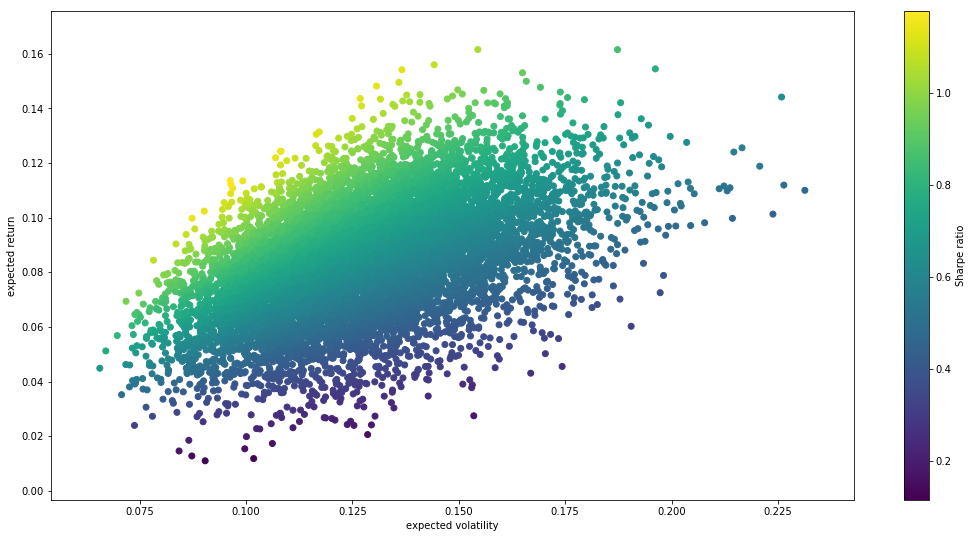

In [13]:
import time
from functools import reduce  
import matplotlib.pyplot as plt
import seaborn as sns
sds = [] # 存放各组合标准差
rtn = [] # 存放各组合收益率
num = 8 # 资产数量
np.random.seed(int(time.time())) # 设置随机数种子

# 模拟1万次
for _ in range(10000):
    w = np.random.rand(num)   # 随机生成各项资产的权重
    w /= sum(w)               # 归一化
    rtn.append(sum(miu_BL * w)) # 计算收益率
    sds.append(np.sqrt(reduce(np.dot, [w, variance_BL, w.T]))) # 计算波动率
    
sds = np.array(sds)
rtn = np.array(rtn)

# xlim(xmin=0)
# ylim(ymin=0)
plt.style.use('seaborn-colorblind')
fig, axes = plt.subplots(1,1,figsize=(18, 9))
plt.scatter(sds, rtn, c=rtn/sds, marker='o')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

In [14]:
import scipy.optimize as sco
import scipy.interpolate as sci

def statistics(w):        
    #根据权重，计算资产组合收益率/波动率/夏普率。
    #输入参数
    #==========
    #weights : array-like 权重数组
    #权重为股票组合中不同股票的权重    
    #返回值
    #=======
    #pret : float
    #      投资组合收益率
    #pvol : float
    #      投资组合波动率
    #pret / pvol : float
    #    夏普率，为组合收益率除以波动率，此处不涉及无风险收益率资产
    #

    w = np.array(w)
    pret = np.sum(miu_BL * w)
    pvol = np.sqrt(reduce(np.dot, [w, variance_BL, w.T]))
    return np.array([pret, pvol, pret / pvol])

def min_func_sharpe(weights):
    # 优化目标函数 -- 最大化夏普率
    return -statistics(weights)[2]

x0 = np.array([1.0 / num for _ in range(num)]) # 初始权重
bounds = tuple((0, 1) for _ in range(num))     # 取值范围(0,1)，不允许做空
'''
约束条件的类型只有'eq'和'ineq'两种
eq表示约束方程的返回结果为0
ineq表示约束方程的返回结果为非负数
'''
constraints = [{'type': 'eq', 'fun': lambda x: sum(x) - 1}] # 约束条件，权重之和等于1
# 用'SLSQP'（Sequential Least Squares Programming）方法寻找最优解
opts = sco.minimize(min_func_sharpe, x0, method='SLSQP',  bounds=bounds, constraints=constraints)
print (opts)

     fun: -1.3269399204275898
     jac: array([  5.51125288e-01,   1.57077760e-02,   4.51520085e-04,
         5.15868694e-01,   1.28172620e+00,  -1.63102150e-03,
         3.32169995e-01,  -1.91837549e-04])
 message: 'Optimization terminated successfully.'
    nfev: 111
     nit: 11
    njev: 11
  status: 0
 success: True
       x: array([  0.00000000e+00,   3.43292852e-16,   5.88046540e-01,
         2.64894521e-17,   9.14752851e-17,   1.29565943e-01,
         2.13712242e-17,   2.82387517e-01])


In [15]:
def min_func_variance(weights):
    # 优化目标函数 -- 最小化方差
    return statistics(weights)[1] ** 2

optv = sco.minimize(min_func_variance, x0, method='SLSQP', bounds=bounds, constraints=constraints)
print (optv)

     fun: 0.0008857395687798231
     jac: array([ 0.00258727,  0.00177045,  0.00206619,  0.00165195,  0.00193645,
        0.00210889,  0.00110336,  0.00177112])
 message: 'Optimization terminated successfully.'
    nfev: 131
     nit: 13
    njev: 13
  status: 0
 success: True
       x: array([  1.53329342e-19,   7.49544962e-02,   2.18098350e-02,
         1.05959106e-03,   7.44497290e-03,   0.00000000e+00,
         9.60329079e-03,   8.85127814e-01])


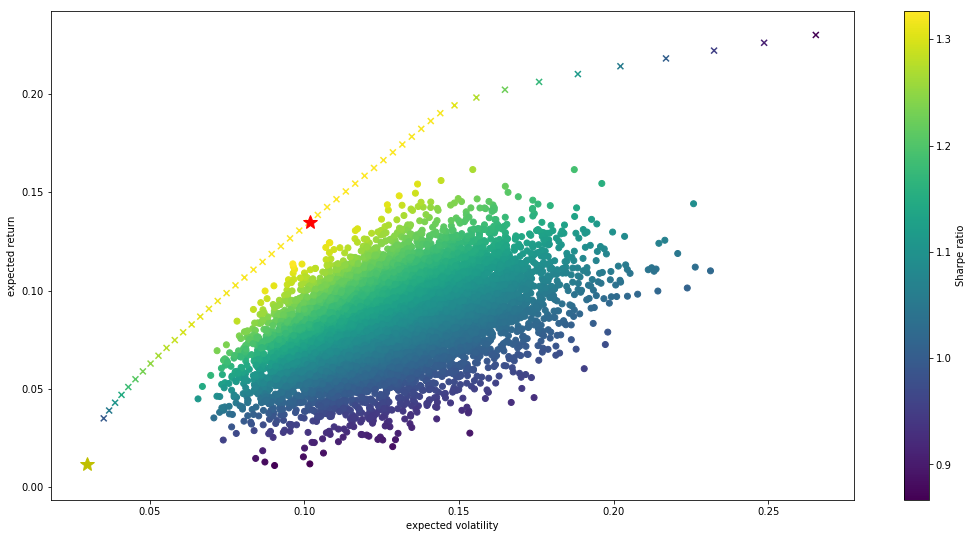

In [16]:
target_returns = np.linspace(0.035, 0.23, 50)
target_volatilities = []

def min_func_port(weights):
    # 优化目标函数 -- 最小化波动率
    return statistics(weights)[1]

for tret in target_returns:
    cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret}, # 给定收益率
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1}) 
    res = sco.minimize(min_func_port, x0, method='SLSQP', bounds=bounds, constraints=cons)
    target_volatilities.append(res['fun'])

fig, axes = plt.subplots(1,1,figsize=(18, 9))
plt.scatter(sds, rtn, c=rtn/sds, marker='o')
#叉叉为有效边界            
plt.scatter(target_volatilities, target_returns, c=target_returns / target_volatilities, marker='x')
#红星为夏普率最大值的资产组合            
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],'r*', markersize=15.0)
#黄星为最小方差的资产组合            
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0],'y*', markersize=15.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

In [17]:
ind = np.argmin(target_volatilities) # 找到target_volatilities最小值的下标
# 通过下标，可以提取边界上半部分的点的集合
upper_half_volatilities = target_volatilities[ind:]
upper_half_returns = target_returns[ind:]
# 通过差值法获得有效前沿的函数特征
tck = sci.splrep(upper_half_volatilities, upper_half_returns)

#利用tck参数构造有效边界函数f(x)
def f(x):
    return sci.splev(x, tck, der=0)

#同时也构造有效边界函数f(x)的一阶导数函数d_f(x)
def d_f(x):
    return sci.splev(x, tck, der=1)

'''
市场投资线满足如下特征：
1. 它是条直线 t(x) = a+bx
2. t(0) = a a是无风险收益
3. 与有效前沿切点的导数为斜率：dt(x) = b
令
p[0] = a
p[1] = b 
p[2] = x
上面三个约束可以用如下代码表示
'''
def equations(p, risk_free_return=0.035):
    eq1 = risk_free_return - p[0] # p(0) = 无风险收益
    eq2 = risk_free_return + p[1] * p[2] - f(p[2]) # 是一条直线a + b*x
    eq3 = p[1] - d_f(p[2]) # 有效前沿切点的斜率就是直线的斜率, dt(x) = b
    return eq1, eq2, eq3

opt = sco.fsolve(equations, [0.01, 0.50, 0.15])
print (opt)

[ 0.035       1.07829177  0.14438065]


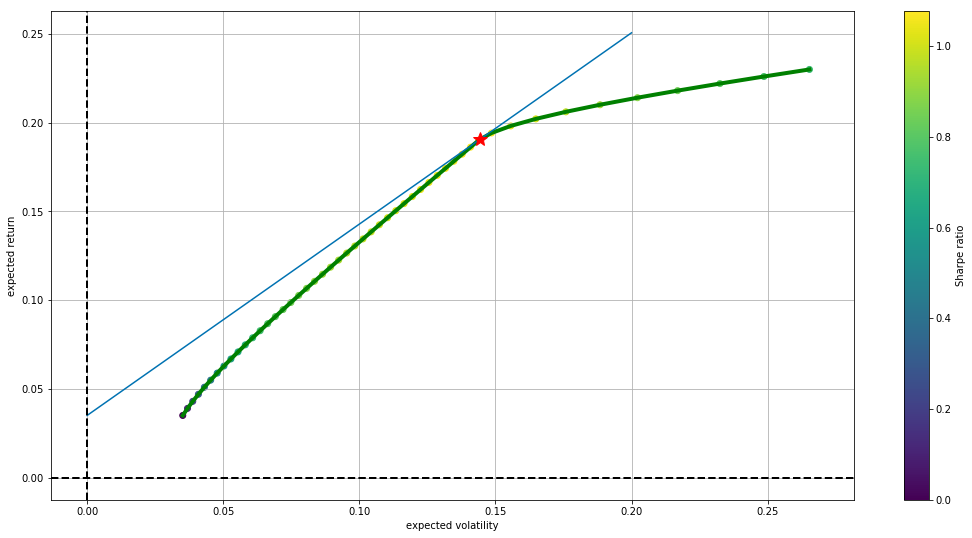

In [18]:
plt.figure(figsize=(18, 9))
#圆点为随机资产组合
plt.scatter(target_volatilities, target_returns, c=(target_returns - 0.035) / target_volatilities, marker='o')
#绿色线为有效边界
plt.plot(upper_half_volatilities, upper_half_returns, 'g', lw=4.0)

#设定资本市场线CML的x范围从0到0.6           
cml_x = np.linspace(0.0, 0.2)
#带入公式a+b*x求得y,作图
plt.plot(cml_x, opt[0] + opt[1] * cml_x, lw=1.5)
#标出资本市场线与有效边界的切点，红星处            
plt.plot(opt[2], f(opt[2]), 'r*', markersize=15.0) 
plt.grid(True)
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

In [175]:
def min_func_return(weights):
    # 优化目标函数 -- 最大化收益
    return -statistics(weights)[0]

# 计算市场投资组合各资产的权重
cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[1] - opt[2]}, # 给定方差
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1}) 
market_portfolio = sco.minimize(min_func_return, x0, method='SLSQP', bounds=bounds, constraints=cons)
w = np.array(market_portfolio.x)
w

array([  0.00000000e+00,   1.05301018e-16,   8.03598390e-01,
         4.94391955e-18,   3.66354455e-17,   1.96401610e-01,
         1.86273133e-18,   1.35281750e-17])

### 新权重在测试集2017年数据上的表现

In [176]:
rateandstd(w)

收益率20.4086% 标准差0.082058


最大回撤-2.69%，发生区间(108, 127)


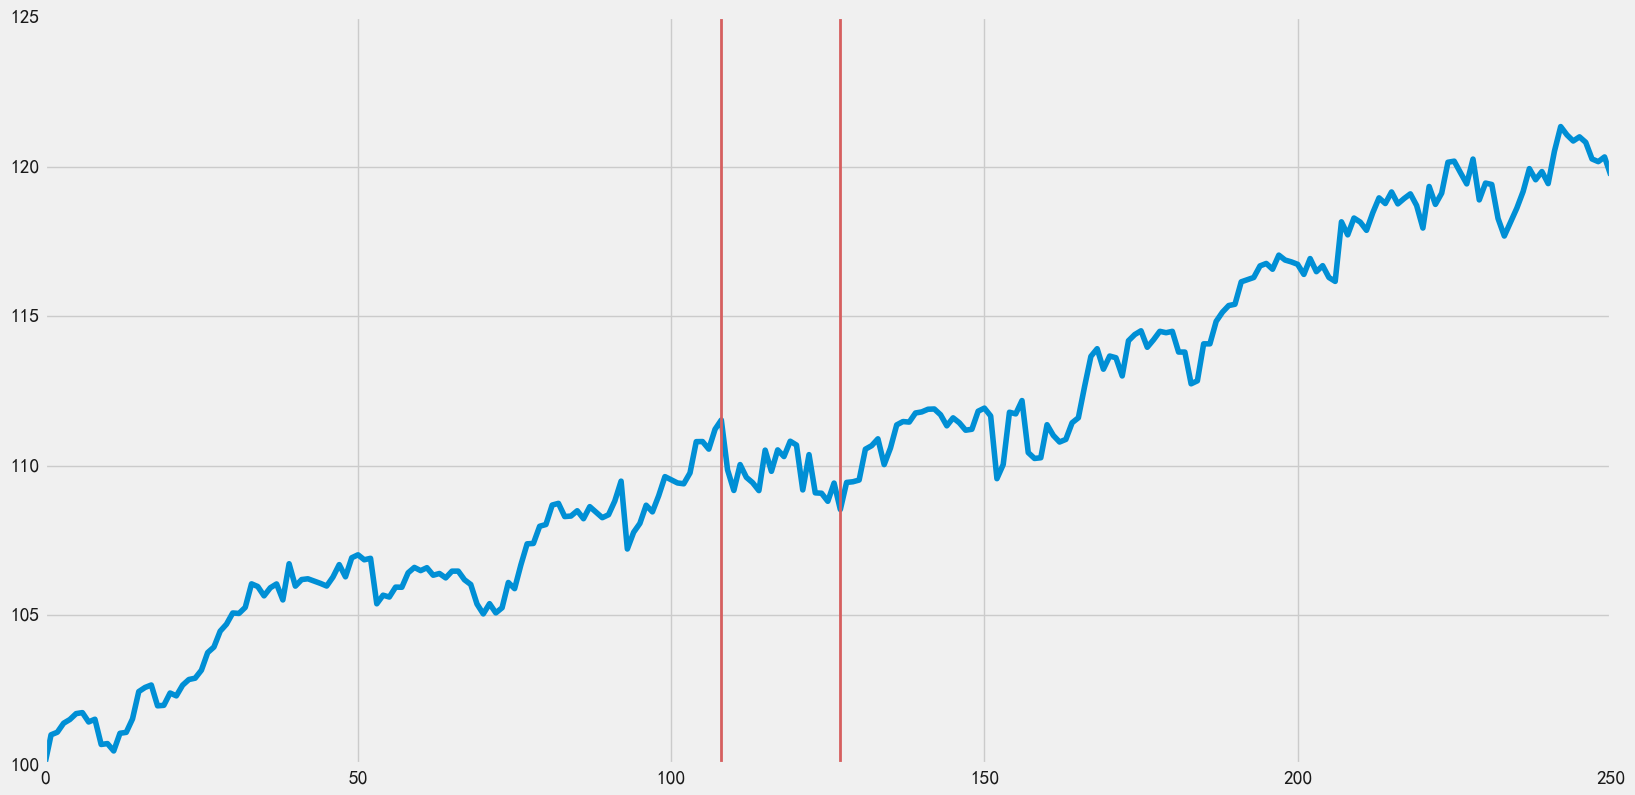

In [177]:
weight = w
portfolio_value = [np.dot(weight.T,close.loc[i]) for i in range(251)]
ddm, start, end = max_draw_down(portfolio_value)
ddm = -ddm*100/portfolio_value[start]
print('最大回撤{:.2f}%，发生区间({}, {})'.format(ddm, start, end))

# 可视化最大回撤
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
fig, axes = plt.subplots(1,1,figsize=(18, 9))
plt.plot(portfolio_value)
plt.axvline(x=start,linewidth=2,color="r")
plt.axvline(x=end,linewidth=2,color="r")
plt.show()

# 结论

以下权重顺序为 GLD	S&P500	NASDAQ	上证指数	深圳成指	创业板指数	恒生指数	美国债券

用5年数据和Markowitz模型构建的资产组合（下记为组合1）的权重为
[ 1.91022870e-17, 1.03053416e-16, 0.738285504, 0, 0, 0.261714496, 0, 0]，在17年数据上的表现: 
收益率为17.9724%，标准差为0.080974。

用5年数据和Black-Litterman模型构建的资产组合（下记为组合2）的权重为:
[ 0, 0, 0.778482946, 0, 2.02474756e-17, 0.221517054, 8.36190926e-18, 0]，在17年数据上的表现: 收益率为19.4718%，标准差为0.081421。

用5年数据和通过马尔可夫转换GARCH-M模型拟合历史5年数据，并预测2017年波动率后优化的
Black-Litterman模型构建的资产组合（下记为组合3）的权重为:
[  0,   0,   0.823385670, 2.55160205e-17, 0, 0.176614330,1.45799781e-17,  5.64738042e-18]
在17年数据上的表现: 收益率为20.4086%，标准差0.082058。

#### 组合1的收益率<组合2的收益率<组合3（优化后）收益率。
#### 组合1的标准差<组合2的标准差<组合3（优化后的）标准差,
#### 主要差异来源于S&P500、纳斯达克和中国创业板的权重不同


#### 最大回撤率用来恒定投资后可能出现的最坏情况，组合1的最大回撤为2.28%，要小于组合2的最大回撤2.55%，组合3的最大回撤为2.69%，但是相对于它的高年化收益率和低标准差，可以认为这是更值得投资的组合。

# 优化模型二

### 有一些资料认为B-L模型的建模原理如下图所示

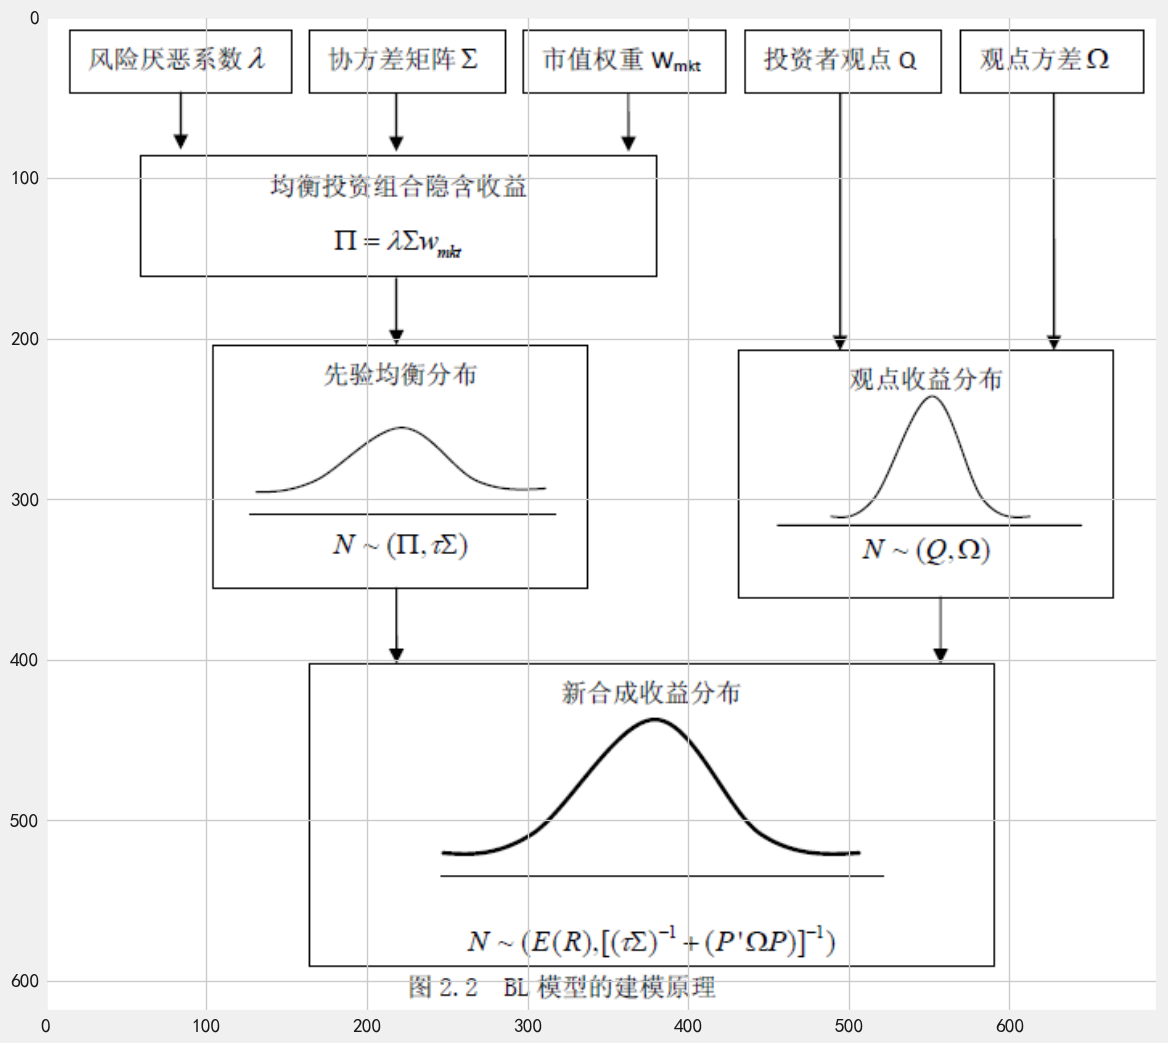

In [178]:
from PIL import Image
import matplotlib.pyplot as plt
img = Image.open('D:\\研一课\\风险管理\\black-litterman模型原理.png')
plt.figure("Black-Litterman",figsize=(18,12))
plt.imshow(img)
plt.show()

以均衡预期收益开始，它将使最优组合具有市场化的权重，假设有两个不同的关于未来超额收益的信息来源：<table>

投资者看法和市场均衡。两种信息来源均不确定，并且以概率 分布的形式表现出来。<table>投资组合最优化的超额预期收益是将两者结合起来的估计

首先根据风险厌恶系数$\lambda$ 、N 个资产超额收益的协方差矩阵$\Sigma$,以及各资产的市值权重$\omega_{mkt}$ <table>

采取逆向优化方法，计算每种资产的均衡收益率$\Pi_i$ ，<table>
从而得出先验均衡分布；再根据投资者对期望收益的观点收益向量Q和<table>
观点误差的协方差矩阵$\Omega$ 得出投资者观点收益分布，由于市场的先验均衡收益和<table>
投资者观点收益都服从正态分布，所以BL 模型新合成的后验分布也服从正态分布。

### 具体公式如下：
<font  size=4>
风险厌恶系数：$\lambda = \frac{\mu_{mkt}}{\sigma^2_{mkt}}$

市场（基准）总期望收益率的方差：$\sigma^2_{mkt} = \omega'_{mkt}\Sigma\omega_{mkt}$<table>

超额隐含均衡收益率向量的估计值：$\Pi = \beta\mu_{mkt}$

各个资产风险度量值：$\beta = \frac{Cov(R,R'\omega_{mkt})}{\sigma^2_{mkt}}$

超额隐含均衡收益率：$\Pi = \frac{Cov(R,R'\omega_{mkt})}{\sigma^2_{mkt}}\mu_{mkt} = \frac{\mu_{mkt}}{\sigma^2_{mkt}}Cov(R,R')\omega_{mkt} = \lambda\Sigma\omega_{mkt}$

BL模型新合并的收益向量:$E[R] = [(\tau\Sigma)^{-1} + P'\Omega^{-1}P]^{-1}[(\tau\Sigma)^{-1}\Pi + P'\Omega^{-1}Q]$

### 市场资本：
#### GLD,S&P500,NASDAQ,'上证指数','深圳成指','创业板指数', '恒生指数','美国债券'（元）


In [19]:
context_market_cap = np.matrix([8923893120,202000000000000,50400000000000,28500000000000,22300000000000,4950000000000,373000000000000,177000000000000])
weq = context_market_cap/np.sum(context_market_cap)
weq

matrix([[  1.03988817e-05,   2.35387636e-01,   5.87303803e-02,
           3.32106317e-02,   2.59858627e-02,   5.76816236e-03,
           4.34651426e-01,   2.06255502e-01]])

In [20]:
#风险厌恶系数lambda刻画了预期的风险与收益的权衡，衡量了投资者为了降低方差而放弃预期收益率
rf = 0.035
year_ret#年化收益率
mu_mkt = float(np.dot(np.matrix(year_ret),np.transpose(weq)))#为市场总期望收益率
covar = np.matrix(returns_df.cov()*250)
sigma = float(np.dot(np.dot(weq,covar),np.transpose(weq)))#市场（基准）总期望收益率的方差
lambd = (mu_mkt -rf)/sigma 
print('资产收益协方差矩阵:')
print(covar)
print('风险厌恶系数:',lambd)

资产收益协方差矩阵:
[[ 0.02720063 -0.00052578 -0.00099143  0.00015715  0.00023581  0.00135442
  -0.001491    0.00150636]
 [-0.00052578  0.01641951  0.01772409  0.0041664   0.00473566  0.004778
   0.00492703 -0.00089379]
 [-0.00099143  0.01772409  0.02200531  0.00514638  0.00580458  0.006048
   0.006086   -0.00095976]
 [ 0.00015715  0.0041664   0.00514638  0.05649314  0.06164196  0.05647681
   0.02043124 -0.00032777]
 [ 0.00023581  0.00473566  0.00580458  0.06164196  0.078268    0.07526586
   0.02229451 -0.00040313]
 [ 0.00135442  0.004778    0.006048    0.05647681  0.07526586  0.11851109
   0.01823376 -0.00024692]
 [-0.001491    0.00492703  0.006086    0.02043124  0.02229451  0.01823376
   0.0290206  -0.00041753]
 [ 0.00150636 -0.00089379 -0.00095976 -0.00032777 -0.00040313 -0.00024692
  -0.00041753  0.00108209]]
风险厌恶系数: 3.1570977122857236


In [21]:
#Π：超额隐含均衡收益率向量（N ×1列向量）
pi = lambd*covar*weq.T
pi

matrix([[-0.00157828],
        [ 0.02257977],
        [ 0.02610406],
        [ 0.04388237],
        [ 0.04918124],
        [ 0.04378695],
        [ 0.04864444],
        [-0.00078237]])

In [22]:
#观点矩阵P和灌顶向量q用上面优化一模型的P，q
P=np.matrix([[ 0, 1, 0, 0, 0, 0, 0, 0],    #标普
            [ 0, -1, 1, 0, 0, 0, 0, 0],   #标普，纳斯达克
            [ 0, 0, 0, 0, 0, 1, 0, 0]])   #创业板

q=np.matrix([0.16, 0.17, 0.2])
tau = 0.2

In [23]:
# tau = 1/returns_df.shape[0]            #tau取1/n
tau = 0.2
corvariance = returns_df.cov()*250     #协方差  8×8
omega = np.diag(np.diag((P*(tau*np.matrix(corvariance))*P.T)))#观点误差的协方差矩阵
omega

array([[ 0.0032839 ,  0.        ,  0.        ],
       [ 0.        ,  0.00059533,  0.        ],
       [ 0.        ,  0.        ,  0.02370222]])

### 由上面求得的$\tau$、$\Omega$、$\mu$、$\Sigma$、$\Pi$代入公式后求得$E(R)$

In [24]:
#新合成（后验）的收益率向量
sub_a = np.linalg.inv(tau*covar) 
sub_b = P.T*np.linalg.inv(omega)*P
sub_c = np.linalg.inv(tau*covar)*pi 
sub_d =  P.T*np.linalg.inv(omega)*q.T
er = np.dot(np.linalg.inv(sub_a+sub_b),(sub_c+sub_d))
miu_BL = np.array(er)[:,0]
#修正后的协方差矩阵为 
variance_BL = np.array(np.linalg.inv((sub_a+sub_b)))
print('修正后的均值：')
miu_BL

修正后的均值：


array([-0.01522991,  0.11011293,  0.19914396,  0.10872933,  0.12667088,
        0.14642479,  0.1033827 , -0.00540402])

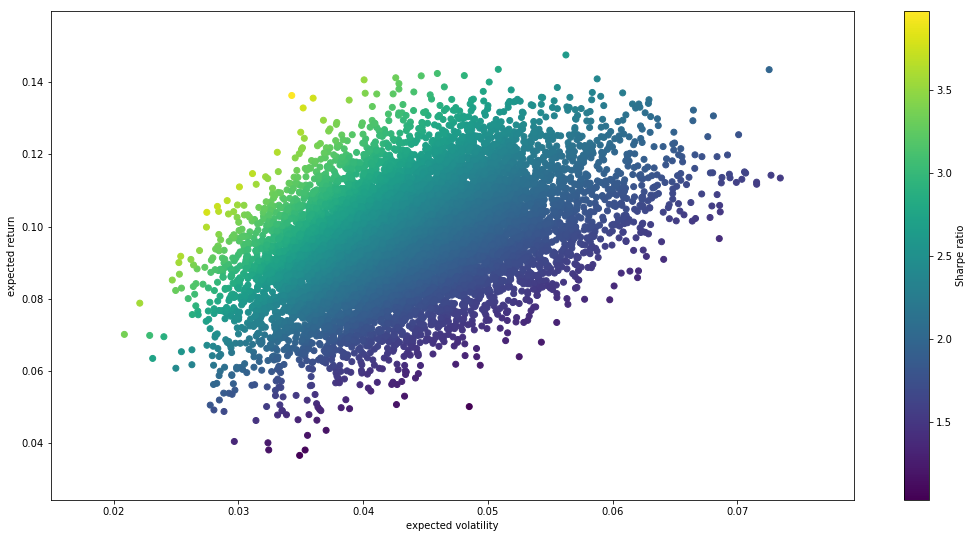

In [25]:
import time

sds = [] # 存放各组合标准差
rtn = [] # 存放各组合收益率
num = len(miu_BL) # 资产数量
np.random.seed(int(time.time())) # 设置随机数种子

# 模拟1万次
for _ in range(10000):
    w = np.random.rand(num)   # 随机生成各项资产的权重
    w /= sum(w)               # 归一化
    rtn.append(float(np.dot(w,miu_BL)))
    sds.append(np.sqrt(reduce(np.dot, [w, variance_BL, w.T]))) # 计算波动率
    
sds = np.array(sds)
rtn = np.array(rtn)

# xlim(xmin=0)
# ylim(ymin=0)
fig, axes = plt.subplots(1,1,figsize=(18, 9))
plt.scatter(sds, rtn, c=rtn/sds, marker='o')
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

In [26]:
import scipy.optimize as sco
import scipy.interpolate as sci

def statistics(w):        
    #根据权重，计算资产组合收益率/波动率/夏普率。
    #输入参数
    #==========
    #weights : array-like 权重数组
    #权重为股票组合中不同股票的权重    
    #返回值
    #=======
    #pret : float
    #      投资组合收益率
    #pvol : float
    #      投资组合波动率
    #pret / pvol : float
    #    夏普率，为组合收益率除以波动率，此处不涉及无风险收益率资产
    #

    w = np.array(w)
    pret = np.sum(miu_BL * w)
    pvol = np.sqrt(reduce(np.dot, [w, variance_BL, w.T]))
    return np.array([pret, pvol, pret / pvol])

def min_func_variance(weights):
    # 优化目标函数 -- 最小化标准差
    return statistics(weights)[1] 


x0 = np.array([1.0 / num for _ in range(num)]) # 初始权重
bounds = tuple((0, 1) for _ in range(num))     # 取值范围(0,1)，不允许做空
'''
约束条件的类型只有'eq'和'ineq'两种
eq表示约束方程的返回结果为0
ineq表示约束方程的返回结果为非负数
'''

constraints = [{'type': 'eq', 'fun': lambda x: sum(x) - 1}] # 约束条件，权重之和等于1
# 用'SLSQP'（Sequential Least Squares Programming）方法寻找最优解
optv = sco.minimize(min_func_variance, x0, method='SLSQP', bounds=bounds, constraints=constraints)
print (optv)


     fun: 0.01271970418454716
     jac: array([ 0.01850765,  0.01280618,  0.01351337,  0.01247994,  0.01314807,
        0.01293218,  0.01251519,  0.0127106 ])
 message: 'Optimization terminated successfully.'
    nfev: 180
     nit: 18
    njev: 18
  status: 0
 success: True
       x: array([ 0.        ,  0.13786513,  0.        ,  0.00547943,  0.        ,
        0.00628776,  0.02152244,  0.82884524])


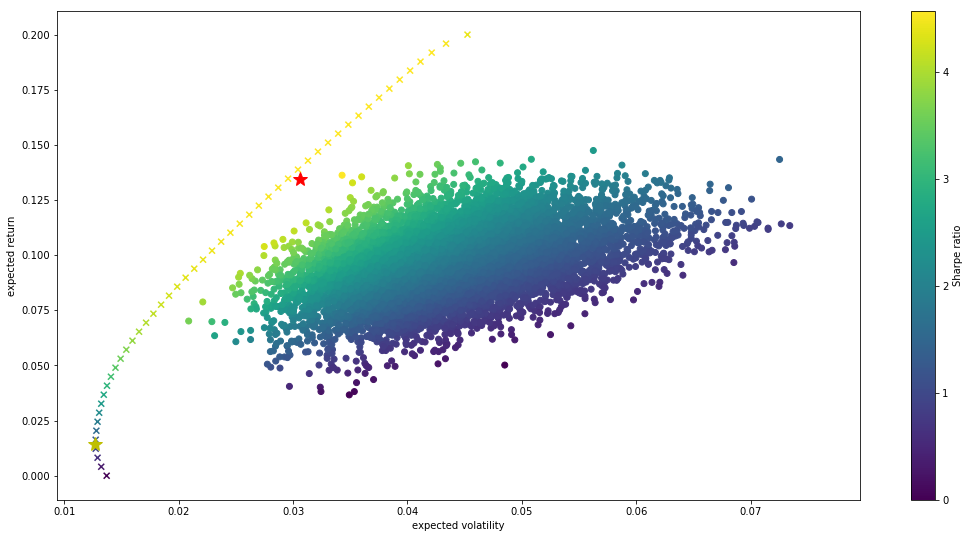

In [33]:
target_returns = np.linspace(0, 0.2, 50)
target_volatilities = []

def min_func_port(weights):
    # 优化目标函数 -- 最小化波动率
    return statistics(weights)[1]

for tret in target_returns:
    cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret}, # 给定收益率
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1}) 
    res = sco.minimize(min_func_port, x0, method='SLSQP', bounds=bounds, constraints=cons)
    target_volatilities.append(res['fun'])

fig, axes = plt.subplots(1,1,figsize=(18, 9))
plt.scatter(sds, rtn, c=rtn/sds, marker='o')
#叉叉为有效边界            
plt.scatter(target_volatilities, target_returns, c=target_returns / target_volatilities, marker='x')
#红星为夏普率最大值的资产组合            
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0],'r*', markersize=15.0)
#黄星为最小方差的资产组合            
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0],'y*', markersize=15.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

In [34]:
ind = np.argmin(target_volatilities) # 找到target_volatilities最小值的下标
# 通过下标，可以提取边界上半部分的点的集合
upper_half_volatilities = target_volatilities[ind:]
upper_half_returns = target_returns[ind:]
# 通过差值法获得有效前沿的函数特征
tck = sci.splrep(upper_half_volatilities, upper_half_returns)

#利用tck参数构造有效边界函数f(x)
def f(x):
    return sci.splev(x, tck, der=0)

#同时也构造有效边界函数f(x)的一阶导数函数d_f(x)
def d_f(x):
    return sci.splev(x, tck, der=1)

'''
市场投资线满足如下特征：
1. 它是条直线 t(x) = a+bx
2. t(0) = a a是无风险收益
3. 与有效前沿切点的导数为斜率：dt(x) = b
令
p[0] = a
p[1] = b 
p[2] = x
上面三个约束可以用如下代码表示
'''
def equations(p, risk_free_return=0.035):
    eq1 = risk_free_return - p[0] # p(0) = 无风险收益
    eq2 = risk_free_return + p[1] * p[2] - f(p[2]) # 是一条直线a + b*x
    eq3 = p[1] - d_f(p[2]) # 有效前沿切点的斜率就是直线的斜率, dt(x) = b
    return eq1, eq2, eq3

opt = sco.fsolve(equations, [0.01, 0.50, 0.15])
print (opt)

[ 0.035       3.7237442   0.04221647]


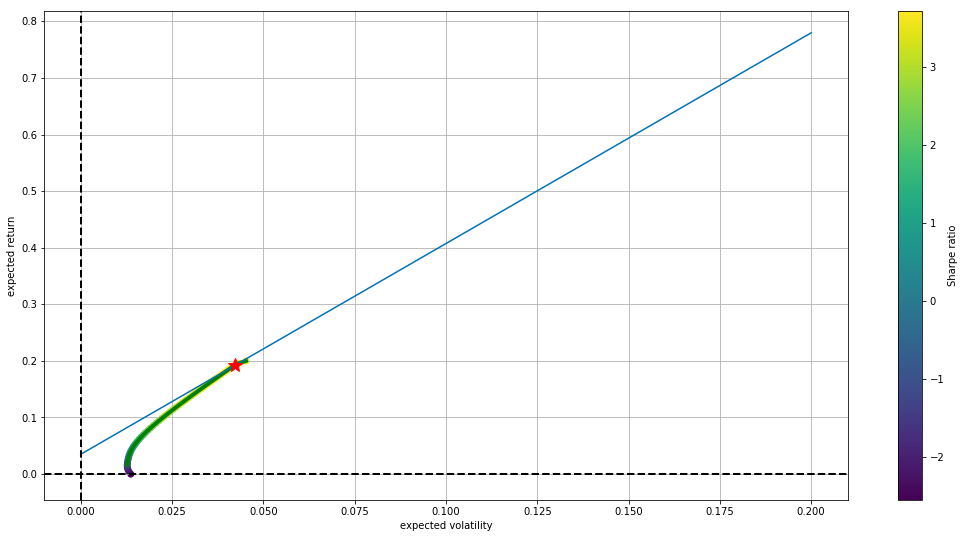

In [35]:
plt.figure(figsize=(18, 9))
#圆点为随机资产组合
plt.scatter(target_volatilities, target_returns, c=(target_returns - 0.035) / target_volatilities, marker='o')
#绿色线为有效边界
plt.plot(upper_half_volatilities, upper_half_returns, 'g', lw=4.0)

#设定资本市场线CML的x范围从0到0.6           
cml_x = np.linspace(0.0, 0.2)
#带入公式a+b*x求得y,作图
plt.plot(cml_x, opt[0] + opt[1] * cml_x, lw=1.5)
#标出资本市场线与有效边界的切点，红星处            
plt.plot(opt[2], f(opt[2]), 'r*', markersize=15.0) 
plt.grid(True)
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')
plt.show()

In [190]:
def min_func_return(weights):
    # 优化目标函数 -- 最大化收益
    return -statistics(weights)[0]

# 计算市场投资组合各资产的权重
cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[1] - opt[2]}, # 给定方差
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1}) 
market_portfolio = sco.minimize(min_func_return, x0, method='SLSQP', bounds=bounds, constraints=cons)
w = np.array(market_portfolio.x)
w

array([  2.28953006e-17,   0.00000000e+00,   8.19714571e-01,
         4.89158757e-03,   0.00000000e+00,   7.67238852e-02,
         5.72003806e-02,   4.14695761e-02])

### 组合4在测试集2017年数据上的投资表现

In [191]:
rateandstd(w)

收益率24.1130% 标准差0.080288


最大回撤-3.08%，发生区间(108, 127)


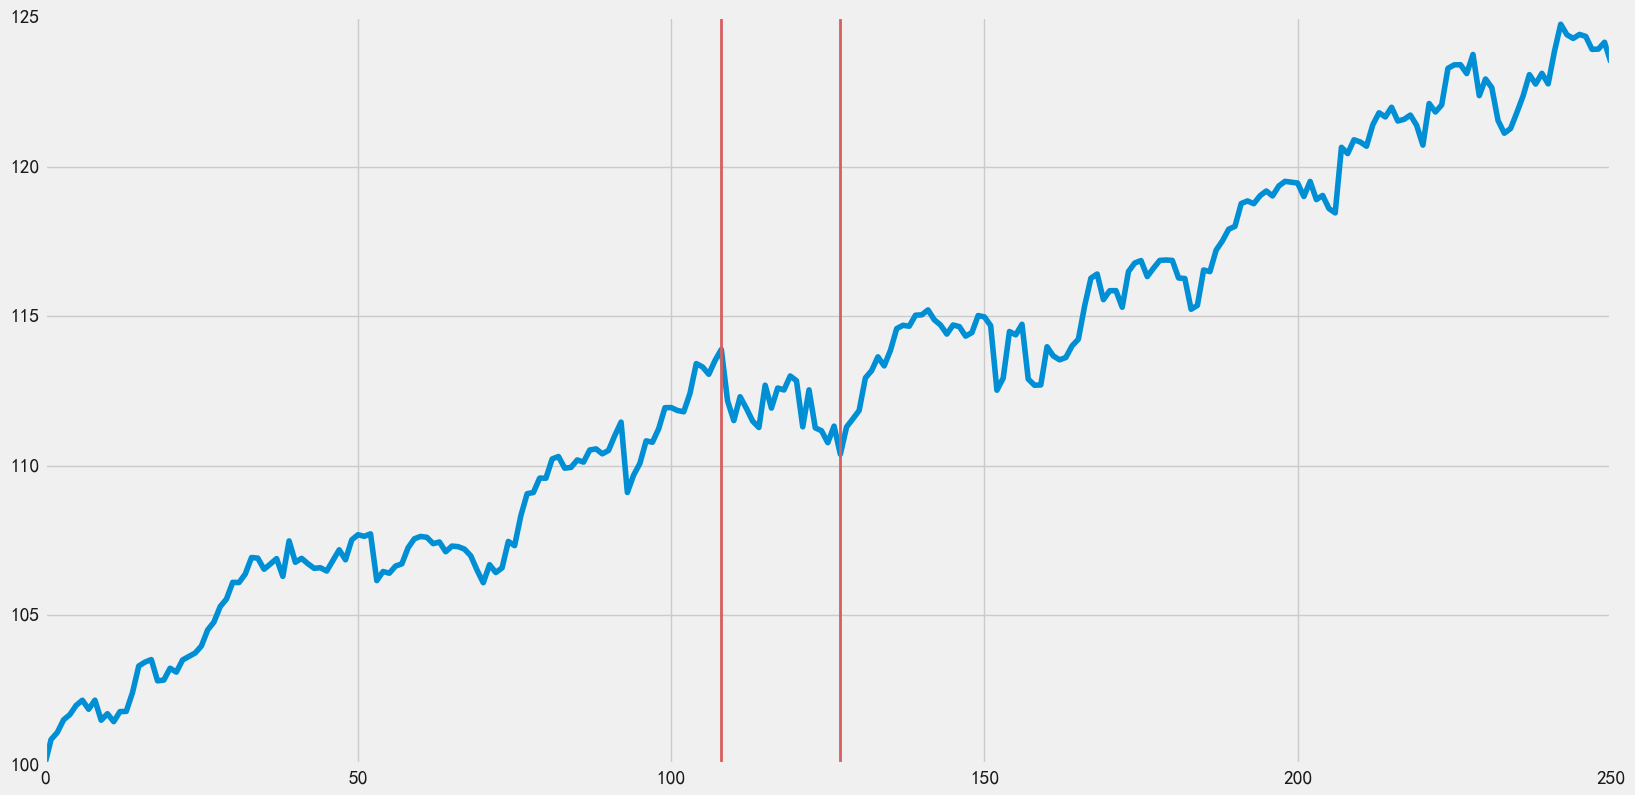

In [192]:
weight = w
portfolio_value = [np.dot(weight.T,close.loc[i]) for i in range(251)]
ddm, start, end = max_draw_down(portfolio_value)
ddm = -ddm*100/portfolio_value[start]
print('最大回撤{:.2f}%，发生区间({}, {})'.format(ddm, start, end))

# 可视化最大回撤
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
fig, axes = plt.subplots(1,1,figsize=(18, 9))
plt.plot(portfolio_value)
plt.axvline(x=start,linewidth=2,color="r")
plt.axvline(x=end,linewidth=2,color="r")
plt.show()

# 结论

以下权重顺序为 GLD	S&P500	NASDAQ	上证指数	深圳成指	创业板指数	恒生指数	美国债券

1、用5年数据和Markowitz模型构建的资产组合（下记为组合1）的权重为
[ 1.91022870e-17, 1.03053416e-16, 0.738285504, 0, 0, 0.261714496, 0, 0]，在17年数据上的表现: 
收益率为17.9724%，标准差为0.080974。

2、用5年数据和Black-Litterman模型构建的资产组合（下记为组合2）的权重为:
[ 0, 0, 0.778482946, 0, 2.02474756e-17, 0.221517054, 8.36190926e-18, 0]，在17年数据上的表现: 收益率为19.4718%，标准差为0.081421。

3、用5年数据和通过马尔可夫转换GARCH-M模型拟合历史5年数据，并预测2017年波动率后优化的
Black-Litterman模型构建的资产组合（下记为组合3）的权重为:
[  0,   0,   0.823385670, 2.55160205e-17, 0, 0.176614330,1.45799781e-17,  5.64738042e-18]
在17年数据上的表现: 收益率为20.4086%，标准差0.082058。

4、在结合3的观点矩阵P和观点向量q上，采用市值权重、风险厌恶系数和协方差矩阵确定市场投资组合隐含收益，继而确定先验均衡分布，然后与主观观点结合估计新的后验收益分布，得到投资组合权重为：[  2.28953006e-17,   0,   0.819714571,         4.89158757e-03,   0,   0.0767238852,  0.0572003806,   0.0414695761]，最后模型结果在17年数据上的表现：收益率24.1130% 标准差0.080288。

#### 组合1的收益率<组合2的收益率<组合3（优化后）收益率<组合4收益率。
#### 组合4的标准差<组合1的标准差<组合2的标准差<组合3（优化后的）标准差,
#### 主要差异来源于S&P500、纳斯达克和中国创业板的权重不同，并且组合4的投资在侧重于纳斯达克上之外的投资更加分散，在创业板、恒生和美债均有一定的投资，从而使得标准差更小。


#### 最大回撤率用来恒定投资后可能出现的最坏情况，组合1的最大回撤为2.28%，要小于组合2的最大回撤2.55%，组合3的最大回撤为2.69%，组合4的最大回撤为3.08%。